# Lineage barcode filtering, processing and clone calling for late allografts multi_seq_19 s2 (multi_bAllos_4_lateAllos_02 s2)

In [16]:
library(ggplot2)
library(ggrepel)
library(plyr)
library(dplyr)
library(Seurat)
library(tidyr) 
library(DescTools)
library(pheatmap)
library(tidyr)
library(purrr)
library(msa)
library(Biostrings)
library(DECIPHER)
library(stringr)
library(stringdist)
library(devtools)

# Lineage analysis functions
source("../LINNAEUS_resources/R_scripts/scar_helper_functions.R")
source("../linBC_processing_and_clone_calling/endo_target_filtering.R")
source("../linBC_processing_and_clone_calling/endo_per_target_clone_calling.R")
source("../linBC_processing_and_clone_calling/clone_def_all_targets.R")
source("../linBC_processing_and_clone_calling/transgene_scar_filtering_functions.R")

# Color palettes and helper functions for plotting
source("../../sc_analysis_palettes_and_helpers.r")

In [17]:
# set a prefix for file naming
dat_name <- "multi_seq_19"

# set working directory to desired output dir
setwd(paste0(getwd(),'/output'))

# create plot output directory if missing
if (!dir.exists(paste0(getwd(),"/pics"))) {
    dir.create(paste0(getwd(),"/pics"), recursive = TRUE)
}

## Endogenous target pre-processing and clustering

### Endogenous gene target lineage barcode filtering and comparison

In [6]:
# Run per dataset
# Load processed Seurat object for that dataset
# Cells must have annotation for tumor sample of origin

load('/data/multi_bAllos_4/multi_bAllos_4_clustered.Robj')

Idents(dat) <- "orig.ident"
dat_sub <- subset(dat, idents = c('multi_bAllos_4_lateAllos_02_S2'))

# Transfer cell type annotation from Seurat object into dataframe and make sure cell barcodes do not have character extensions that prohibit matching to cell barcodes in the lineage data.
cell_anno <- dat_sub@meta.data
cell_anno$Barcode <- substr(rownames(cell_anno),17,32)


In [8]:
## Name genes used for endogenous target gene filtering.

gene_names <- c("actb1", "actb2","rpl39","cfl1","rpl18a")
genes_list <- c("actb1", "actb2","rpl39","cfl1","rpl18a")


In [9]:
## Set filtering parameters for endogenous target gene filtering.
# Fraction is the fraction of UMIs considered for filtering per cell set for each gene.
fraction <- c(0.8, 0.8, 0.8, 0.8, 0.8)

# Read cut-offs per UMI and cell for it a molecule to be considered.
# Defaults work well, but you can base this on the statistics and read distribution plots produced later, come back here and re-run.
read_cutoffs <- c("actb1" = 8,
                  "rpl39" = 3,
                  "cfl1" = 10,
                  "rpl18a" = 10,
                  "actb2" = 3
)

In [19]:
# Run UMI-filtering for endogenous target genes.
scars <- UMI_filtering_wrap(input_dat_name = "multi_bAllos_4_lateAllos_02_s2_scars_UMIw_read_counts.txt",
                            input_dat_wd = "/data/multi_bAllos_4/lineage/lateAllos_02/",
                            dat_name = dat_name,
                            fraction = fraction,
                            gene_names = gene_names,
                            seur_dat = dat,
                            scars_from_trans = F,
                            read_cutoffs = read_cutoffs)

[1] "actb1"
actb1 
    8 
[1] "rpl39"
rpl39 
    3 
[1] "cfl1"
cfl1 
  10 
[1] "rpl18a"
rpl18a 
    10 
[1] "actb2"
actb2 
    3 


In [20]:
# Look at statistics across lineage barcode filtering steps
scars$Statistics

Var1,Cells_after_whitelisting,Cells_after_readfiltering,Cells_after_UMIfilter,Cells_after_Ambigene_removal,Cells_after_doublet_removal
<fct>,<int>,<int>,<int>,<int>,<int>
actb1,6659,6588,6588,6570,6569
actb2,8910,8885,8885,8873,8873
cfl1,5176,4956,4956,4956,4955
rpl18a,683,604,604,604,604
rpl39,9021,8967,8967,8810,8810


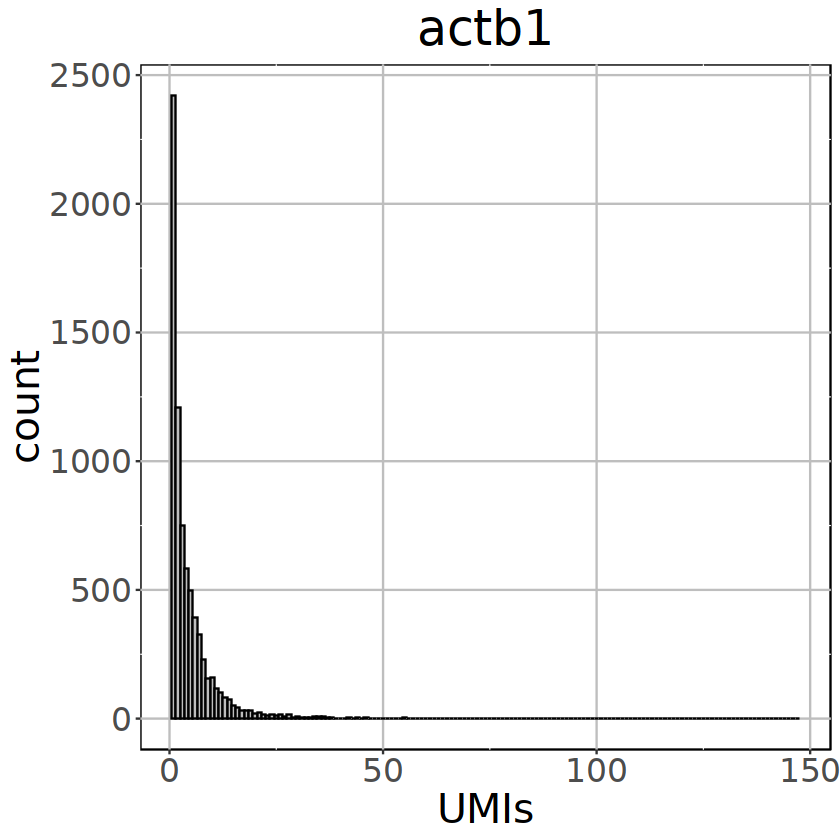

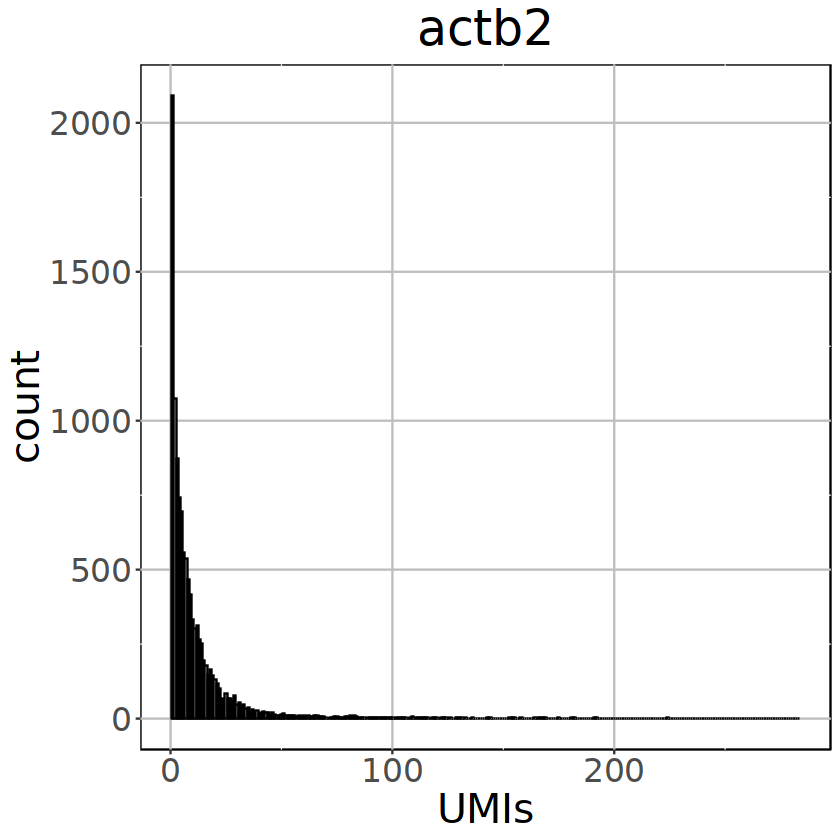

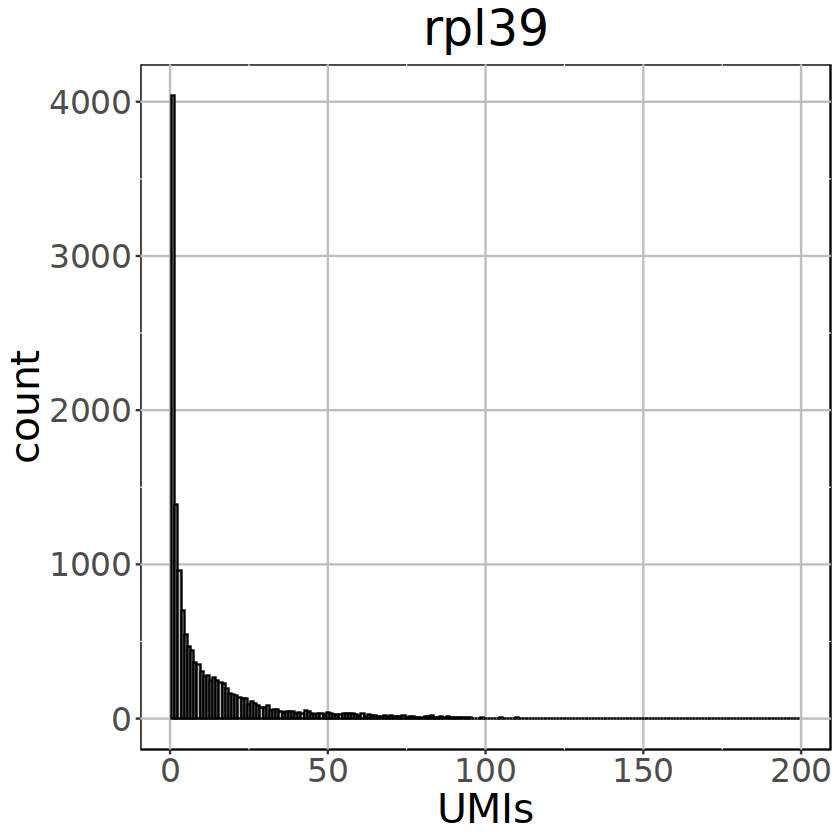

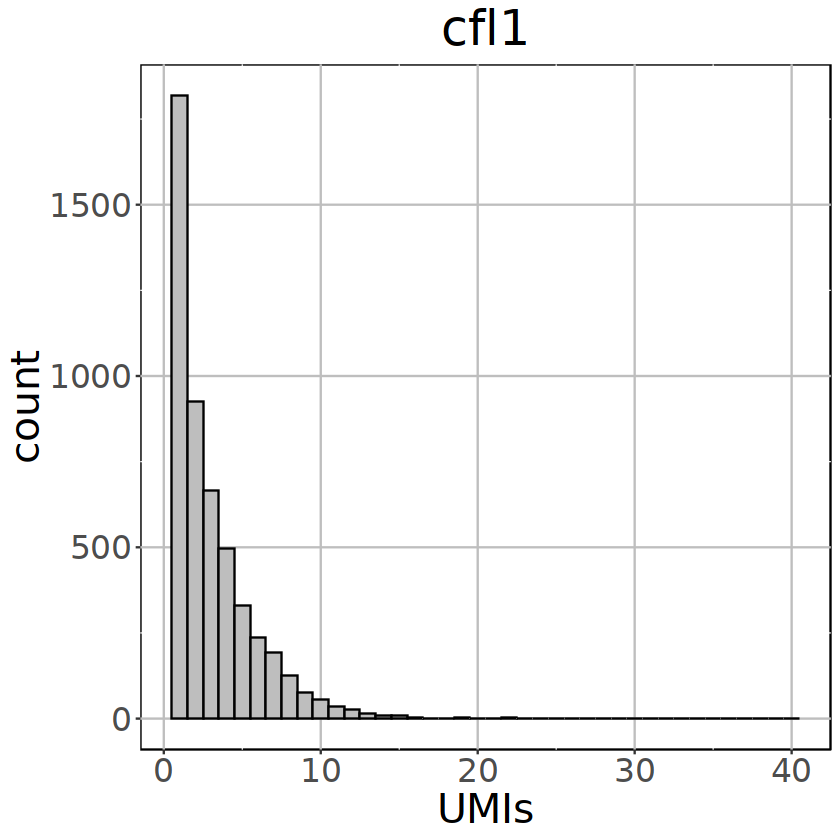

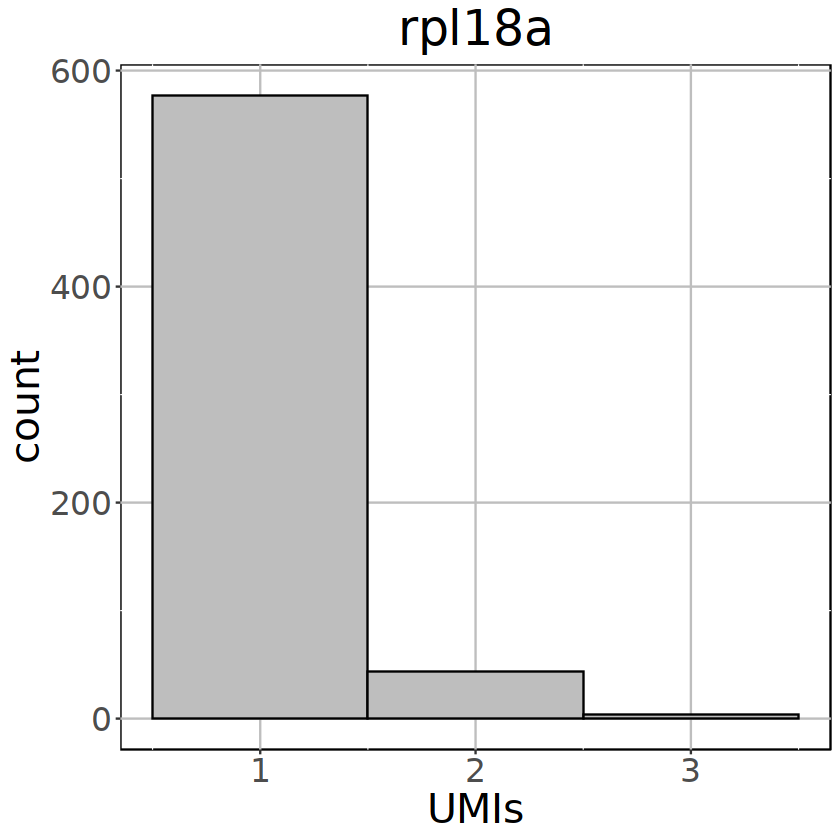

In [21]:
# Save output object
save(scars, file = paste0("Endo_scars_filtering_",dat_name,"_WLinput.Robj"))

# Check distribution of UMI-counts per allele for each gene

for(i in 1:length(gene_names)){
    
    gene_name <- gene_names[i]
    
    print(
          ggplot(scars$UMI_counted[scars$UMI_counted$Gene == gene_name, ]) +
              geom_histogram(aes(x = UMIs), binwidth = 1,color="black", fill="grey") +
              ggtitle(paste0(gene_name))
         )
    
    }

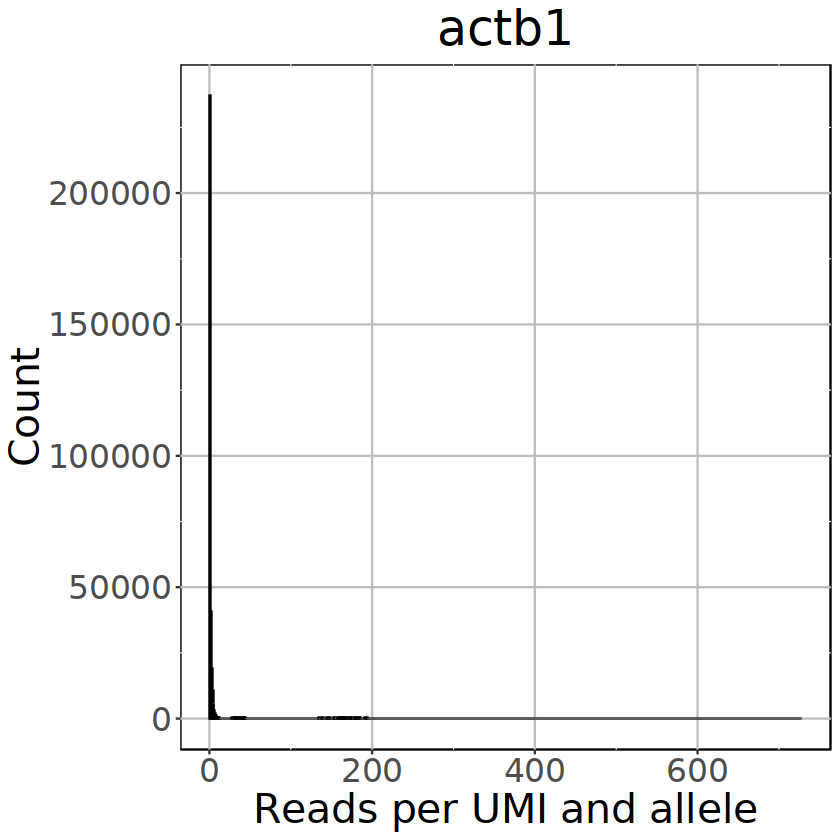

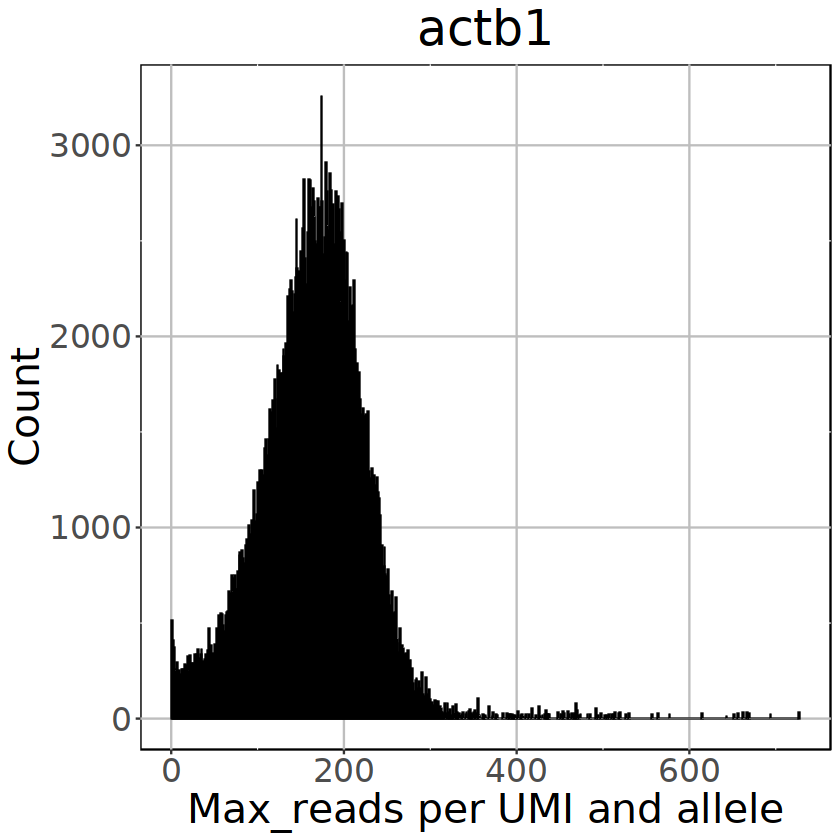

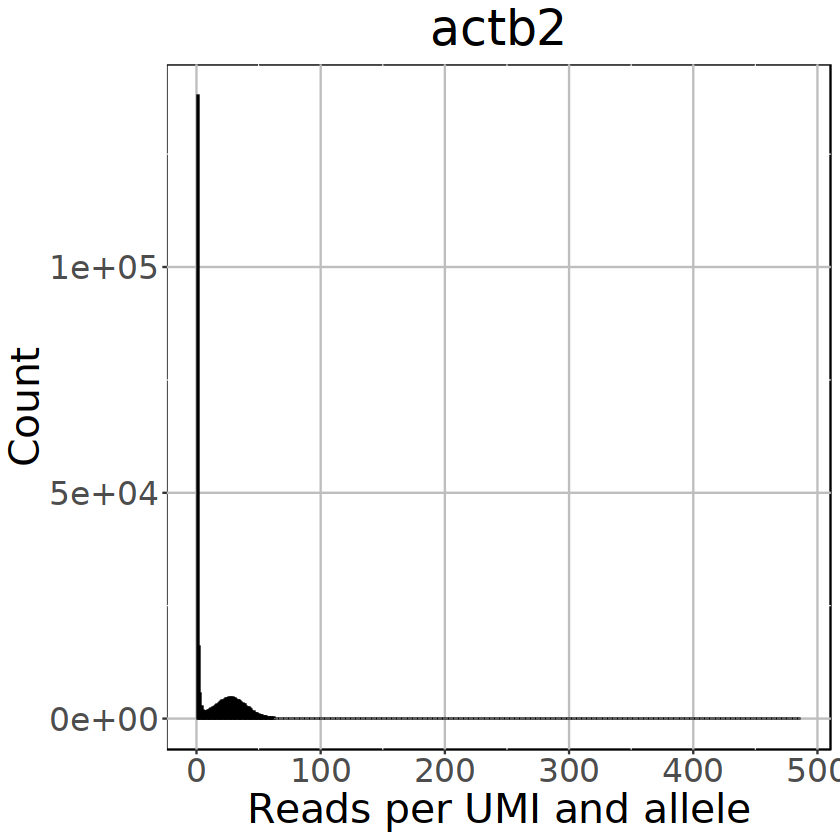

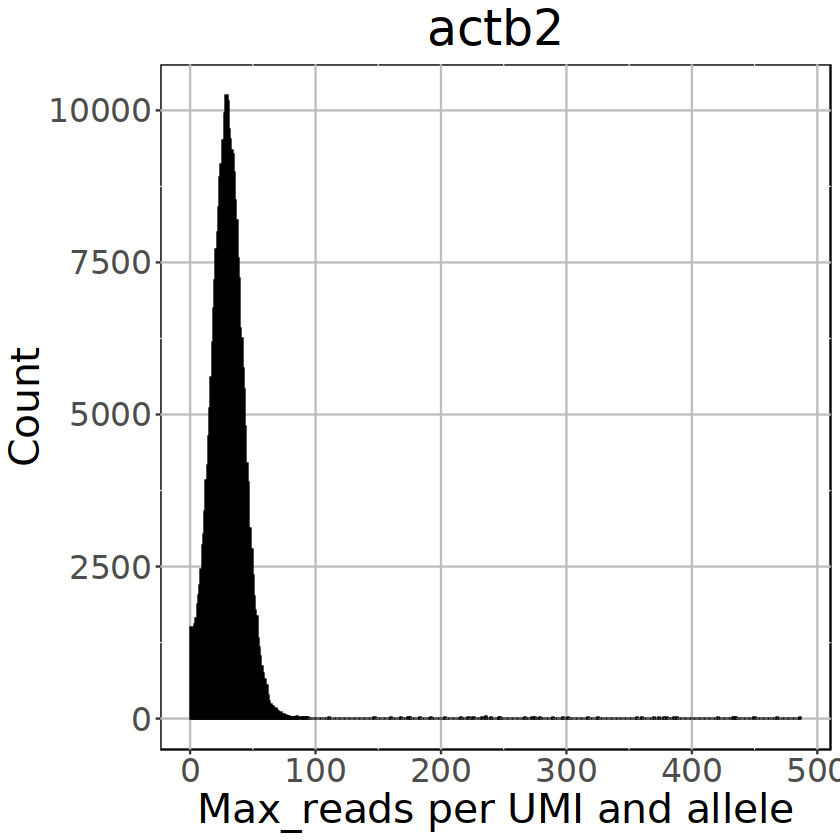

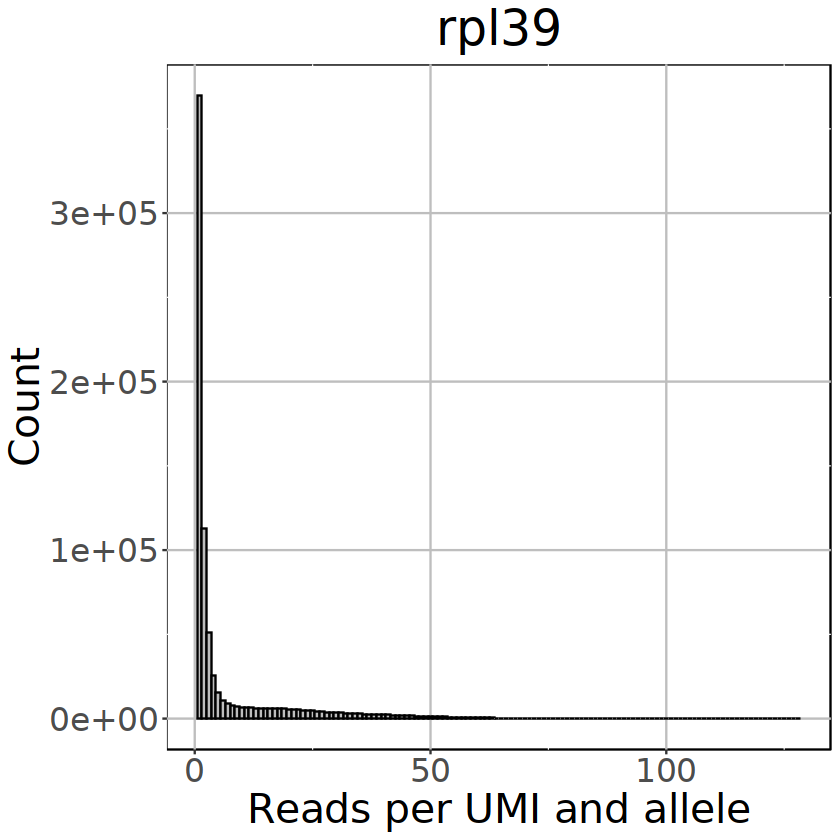

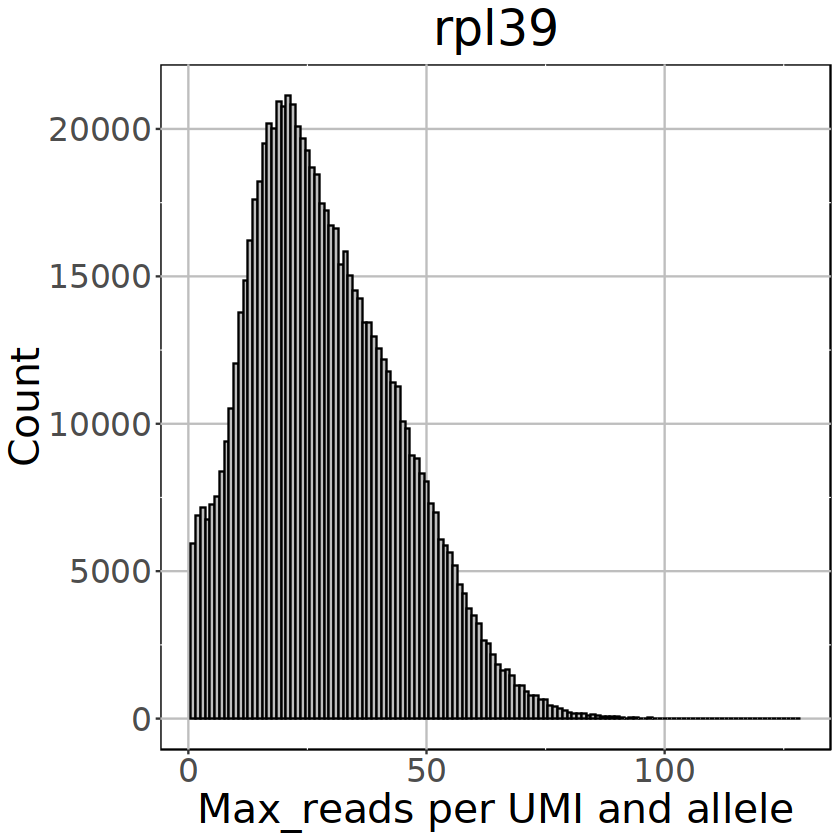

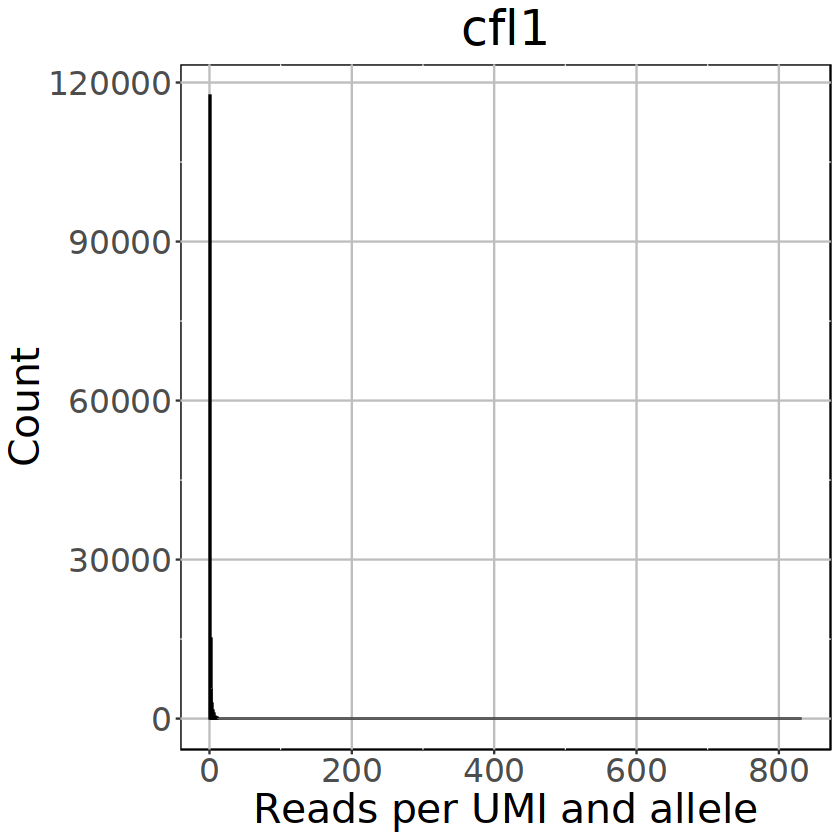

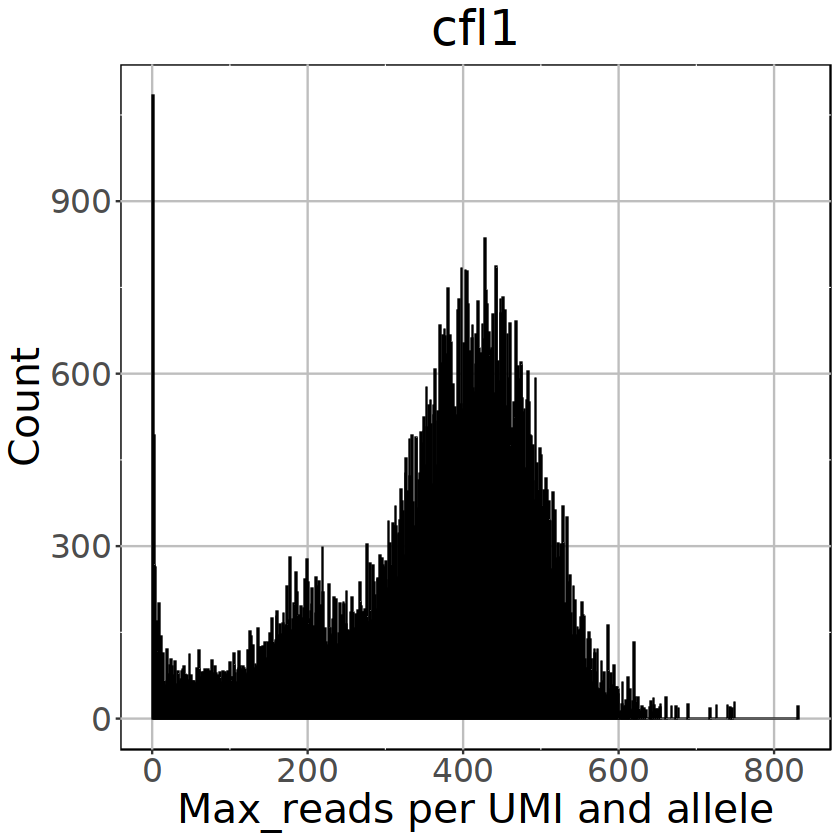

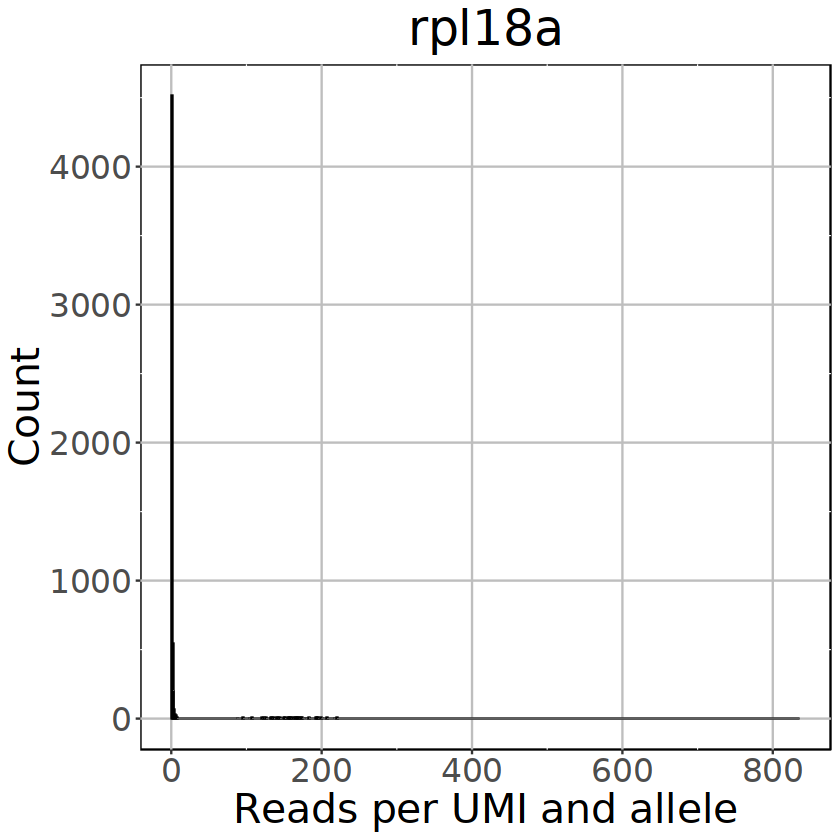

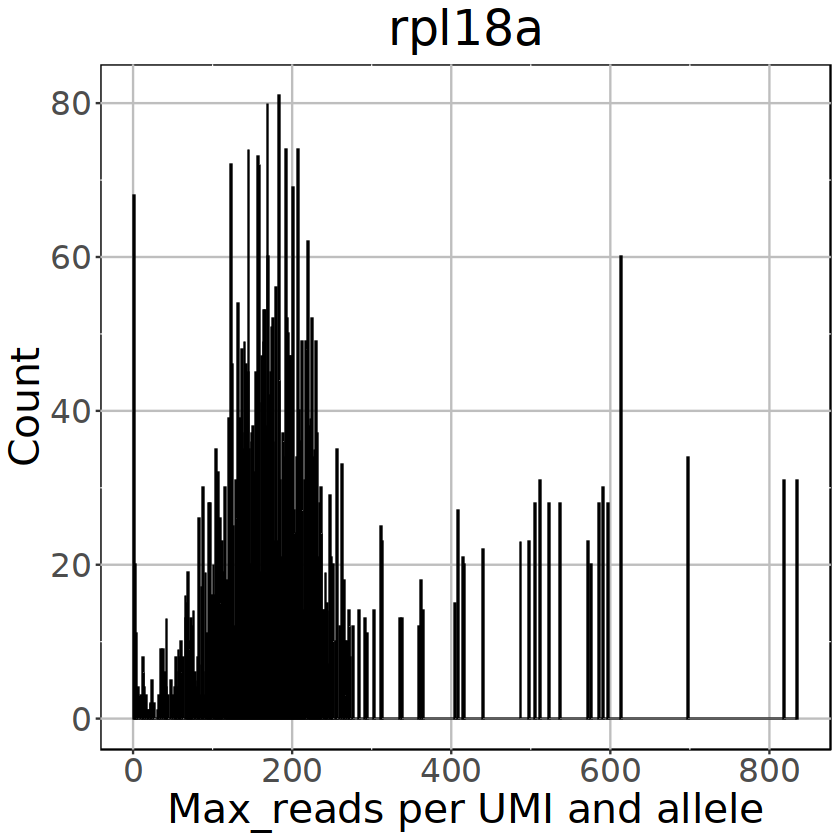

In [22]:
# Plot number of reads per UMI and allele for each gene.
# Use these distributions to set initial read-filtering cut-off below.

for(i in 1:length(genes_list)){

    gene <- genes_list[i]

    scars_input <- scars$Input
    scars_input$Reads <- as.numeric(scars_input$Reads)
    scars_input$Max_reads <- as.numeric(scars_input$Max_reads)

    # Plot number of reads per cell, UMI and allele
    print(ggplot(scars_input[scars_input$Gene == gene,]) +
                geom_histogram(aes(x = Reads), binwidth = 1,color="black", fill="grey") +
                labs(title = paste0(gene), x = 'Reads per UMI and allele', y = 'Count')
    )

    # Plot the maximum number of reads found for a given UMI-allele combination. All other reads from that UMI with another allele are likely sequencing errors.
    print(ggplot(scars_input[scars_input$Gene == gene,]) +
                geom_histogram(aes(x = Max_reads), binwidth = 1,color="black", fill="grey") +
                labs(title = paste0(gene), x = 'Max_reads per UMI and allele', y = 'Count')
    )

    
}

#### Perform lineage barcode comparison to remove frequently created lineage barcodes

In [24]:
# Load filtered lineage barcode data

load("Endo_scars_filtering_multi_seq_19_WLinput.Robj") # loads object 'scars'

f_scars_in_trnscrptm <- scars$Filtering_output[scars$Filtering_output$Barcode %in% cell_anno$Barcode,]
f_scars_in_trnscrptm <- f_scars_in_trnscrptm[f_scars_in_trnscrptm$Barcode %in% unique(scars$Stats_per_cell[scars$Stats_per_cell$Over == F,]$Barcode, scars$Stats_per_cell[scars$Stats_per_cell$Doublet == F,]$Barcode),]


# Adjust names of the cells to match the cell names in the Seurat object

# Extract cell barcode prefix and suffix
prefix <- if (grepl("_", rownames(cell_anno)[1])) sub("^(.*_).*", "\\1", rownames(cell_anno)[1]) else ""
suffix <- if (grepl("-", rownames(cell_anno)[1])) sub(".*(-.*)$", "\\1", rownames(cell_anno)[1]) else ""

# Add to cells in lineage barcode dataframe
f_scars_in_trnscrptm$Barcode <- paste0(prefix,f_scars_in_trnscrptm$Barcode,suffix)
rm(scars)

In [25]:
# Run lineage barcode comparison to lineage barcodes recovered from bulk larval experiments.

# Load cell type annotation
cell_anno <- dat@meta.data
cell_anno$Barcode <- rownames(cell_anno)

scar_probabilities_in <- read.csv("../../linBC_processing_and_clone_calling/Gene_scar_probs.csv",
                                       stringsAsFactors = F)

# Run function. The output will be written into the working directory.
# Output tables start with 'Z1_scars_compared'.
compare_scars(input_dat_name = f_scars_in_trnscrptm, # output of the scar filtering
                          dat_name = dat_name, # output dat_name
                          min.presence = 2, # Cells that have to have a scar for it to be considered present in an organism
                          gene_names = c("actb1", "actb2","rpl39","cfl1","rpl18a"), # all genes that you want to screen
                          scar_probabilities_in = scar_probabilities_in, # scar probabilities generated from bulk sequencing of many larvae
                          seur_dat = cell_anno, # a seurat metadata file that contains all valid cell barcodes (16-base-barcode only) in a column named "Barcode"
                          primer_set = "01" # can be either "01" or "02" depending on which primer set was used. Here, only set 01 was used!
                         )


[1] "Starting with 35057 entries in scar file."
[1] "Comparing gene actb1"


Warning message in min(unique.scars_2$p, na.rm = T):
“no non-missing arguments to min; returning Inf”


[1] "Comparing gene actb2"


Warning message in min(unique.scars_2$p, na.rm = T):
“no non-missing arguments to min; returning Inf”


[1] "Comparing gene rpl39"


Warning message in min(unique.scars_2$p, na.rm = T):
“no non-missing arguments to min; returning Inf”


[1] "Comparing gene cfl1"
[1] "Comparing gene rpl18a"


Warning message in min(unique.scars_2$p, na.rm = T):
“no non-missing arguments to min; returning Inf”


### Extraction of allele pairs for individual endogenous target genes

In [32]:
# Subset for sample you want to work with, if necessary, and of course only if you work with a seurat object that consists of multiple merged datasets

cell_anno$sample_inf <- paste0('multi_seq_19',cell_anno$fish_all)

In [29]:
# set variables for running the following functions

dat_wd  <- getwd()
dat_name <- "multi_seq_19"
seur_dat <- cell_anno
tums_list <- c("all")

[1] "entries in scar input object for gene actb1: 7160"
[1] "Isolated 10 clone IDs for gene actb1."
[1] "add WT seqs"
[1] "entries in scar input object for gene actb2: 10734"


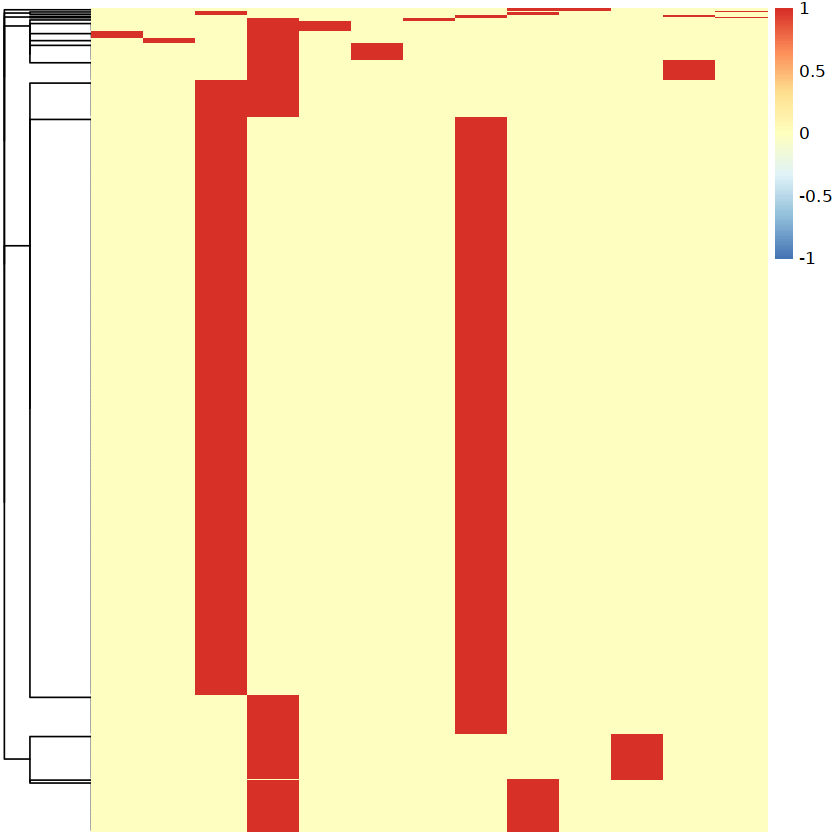

[1] "Isolated 9 clone IDs for gene actb2."
[1] "add WT seqs"
[1] "entries in scar input object for gene rpl39: 11534"


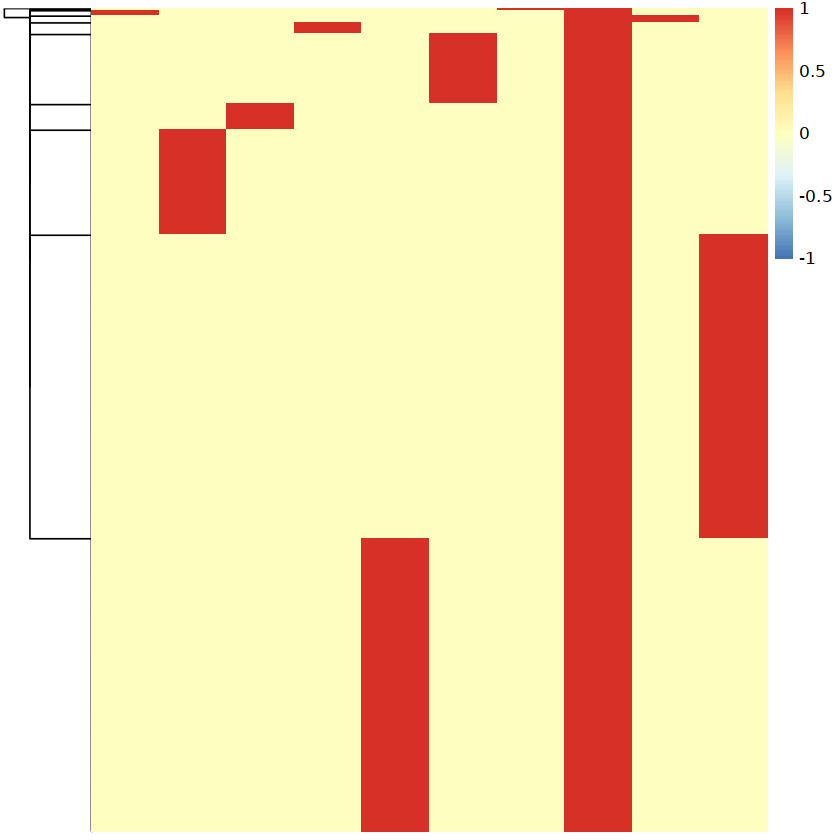

[1] "Isolated 21 clone IDs for gene rpl39."
[1] "add WT seqs"
[1] "entries in scar input object for gene cfl1: 5004"


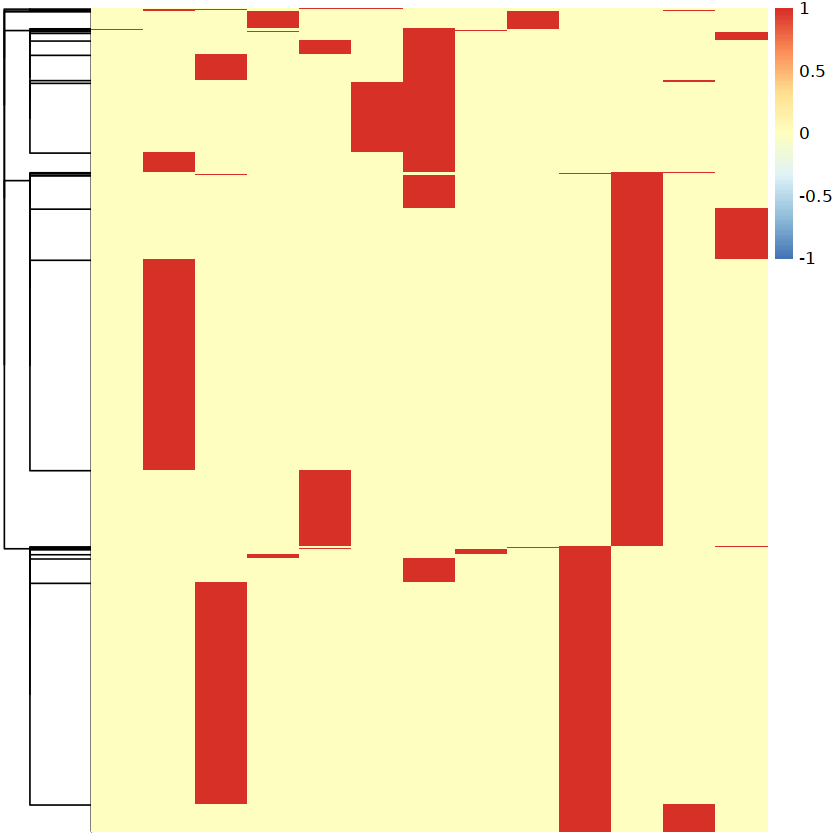

[1] "Isolated 3 clone IDs for gene cfl1."
[1] "add WT seqs"
[1] "entries in scar input object for gene rpl18a: 625"


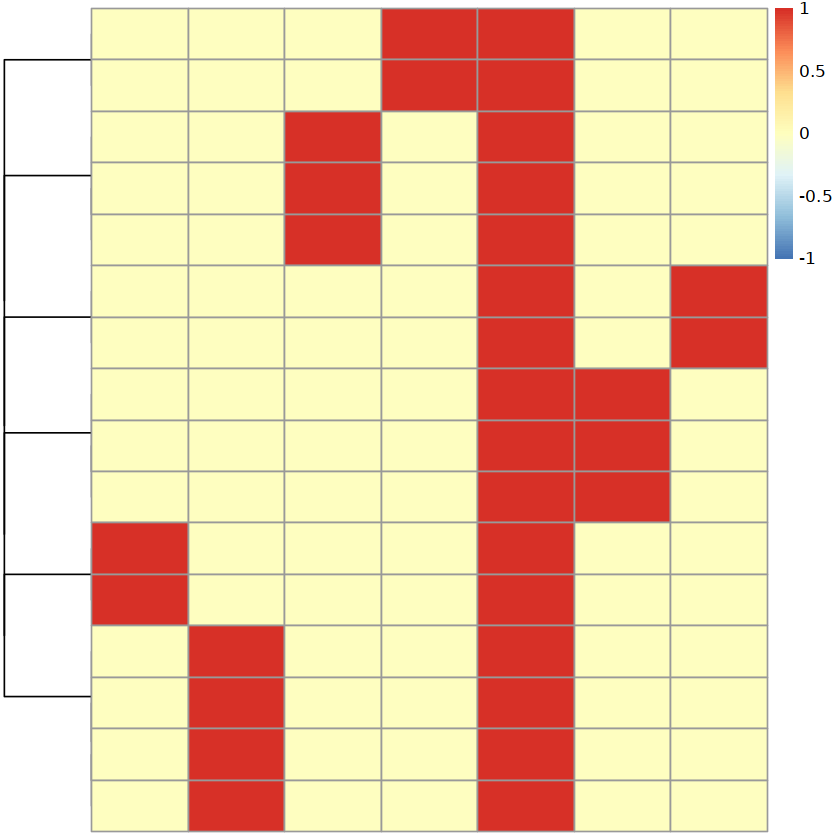

[1] "Isolated 1 clone IDs for gene rpl18a."
[1] "add WT seqs"


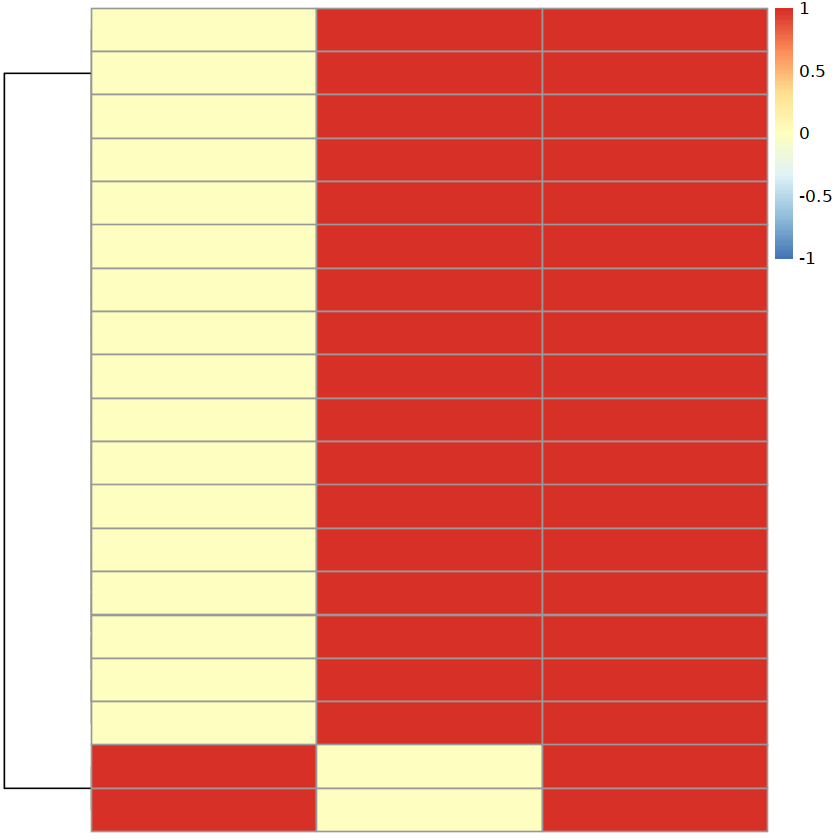

In [33]:
# Get seq-IDs, i.e. pairs of sequence IDs observed together in the same cell consistently

getvalidseqids(dat_wd = dat_wd,
               dat_name = dat_name,
               wt_seq_ids = wt_seq_ids,
               seq_id_delim = seq_id_delim,
               scar_file_name = 'Z1_scars_compared_multi_seq_19',
               heatmap_after_initial_filt = T,
               seur_dat = cell_anno,
               tums_list = tums_list,
               genes_list = genes_list)

## dsRedRecCas (transgene) filtering and pre-processing

In [46]:
# Pre-process scar output files: merge with succesful whole-transcriptome, barcodes, remove missequenced scars per cell, validate outcome by hand.

# Enter name for lineage barcode target gene.
scar_name <- "dsRedRecCas"

# Load lineage barcode data generated during scar extraction.
scars.in <- read.csv("/data/lineage/lateAllos_02_s2_reccas_scar_filtered_scars.csv", stringsAsFactors = F, sep = "\t")

# Adjust names of the cells to match the cell names in the Seurat object
# Extract cell barcode prefix and suffix
prefix <- if (grepl("_", rownames(cell_anno)[1])) sub("^(.*_).*", "\\1", rownames(cell_anno)[1]) else ""
suffix <- if (grepl("-", rownames(cell_anno)[1])) sub(".*(-.*)$", "\\1", rownames(cell_anno)[1]) else ""
# Add to cells in lineage barcode dataframe
scars.in$Cell <- paste0(prefix,scars.in$Barcode,suffix)
scars.in$Barcode <- paste0(prefix,scars.in$Barcode,suffix)


In [47]:
# Select only cells that exist in the Seurat data data

scars.unfiltered <- inner_join(scars.in, cell_anno[, c("Barcode", "seurat_clusters","fish_all","tumour_all")], by = "Barcode")
scars.unfiltered$Scar.id <- 1:nrow(scars.unfiltered)
scars.unfiltered$Keep <- T
scars.unfiltered$Pair <- "With"
cells <- unique(scars.unfiltered$Cell)
print(paste0('Unfiltered lineage barcode data for ', length(cells), ' cells'))


[1] "Unfiltered lineage barcode data for 3846 cells"


In [49]:
# Load lineage barcode data generated during scar extraction: Read in all >1 read sequences (all UMIs)
all.scars.g1 <- read.table("/data/lineage/lateAllos_02_s2_reccas_scar_reads_over1.txt",sep = "\t", stringsAsFactors = F)

colnames(all.scars.g1)[-1] <- c("Barcode", "UMI", "Location", "Sequence")
all.scars.g1$V11 <- trimws(all.scars.g1$V1)
all.scars.g1$Reads <- sapply(all.scars.g1$V11,
                             function(x) unlist(strsplit(x, " "))[1])
all.scars.g1$CIGAR <- sapply(all.scars.g1$V11,
                             function(x) unlist(strsplit(x, " "))[2])

                             

# Adjust names of the cells to match the cell names in the Seurat object
# Extract cell barcode prefix and suffix
prefix <- if (grepl("_", rownames(cell_anno)[1])) sub("^(.*_).*", "\\1", rownames(cell_anno)[1]) else ""
suffix <- if (grepl("-", rownames(cell_anno)[1])) sub(".*(-.*)$", "\\1", rownames(cell_anno)[1]) else ""
# Add to cells in lineage barcode dataframe
all.scars.g1$Cell <- paste0(prefix, all.scars.g1$Barcode,suffix)

                      
all.barcode.UMIs <-
  data.frame(table(all.scars.g1$Sequence, all.scars.g1$Cell))
all.barcode.UMIs <- all.barcode.UMIs[all.barcode.UMIs$Freq > 0, ]

colnames(all.barcode.UMIs) <- c("Sequence", "Barcode", "UMIs")

all.barcode.UMIs_sec <-
  data.frame(table(all.scars.g1$Sequence, all.scars.g1$Barcode))
all.barcode.UMIs_sec <- all.barcode.UMIs_sec[all.barcode.UMIs_sec$Freq > 0, ]

colnames(all.barcode.UMIs_sec) <- c("Sequence", "Barcode", "UMIs")

In [51]:
# Run lineage barcode filtering functions for transgenic targets

# Parameters 
log2.cutoff = 3

scars.output <- filter_RFP_scars(unfilt_scar_file_1 = scars.unfiltered,
                                 unfilt_scar_file_2 = all.scars.g1, 
                                 all_barcode_UMIs_file = all.barcode.UMIs,
                                 all_cells = cells
                                )


#### Additional manual filtering

Warning message:
“Removed 1879 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range (`geom_bar()`).”


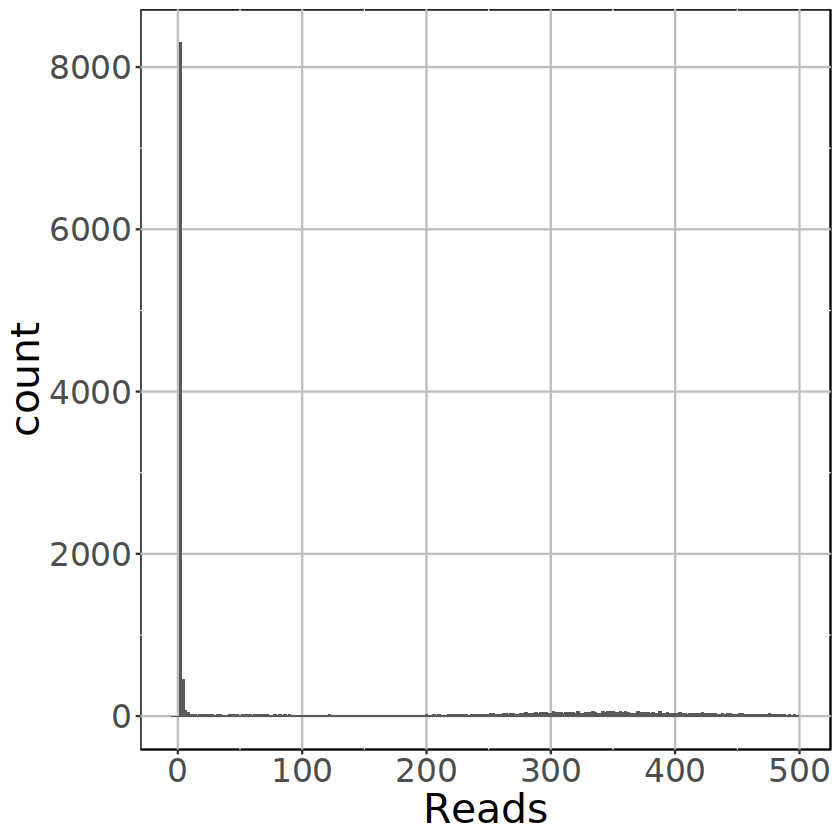

Warning message:
“Removed 1879 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range (`geom_bar()`).”


png 
  2

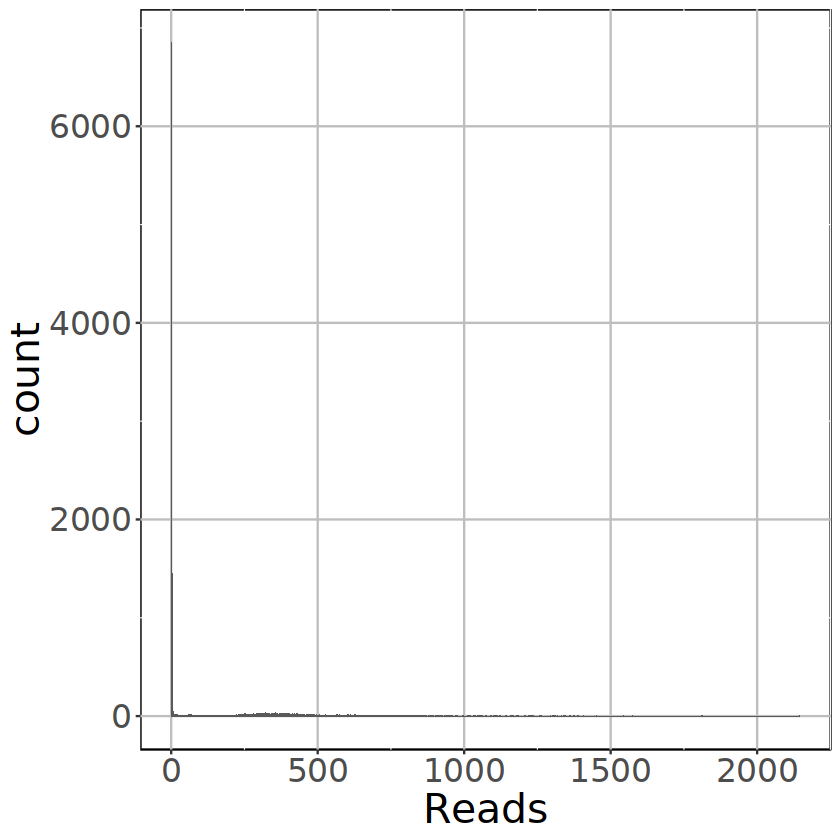

In [52]:
# We use two final filters for the scar data. The first is an undersequencing filter;
# this removes all scars whose read number is under a cutoff. This cutoff is determined based on the histogram of reads per observed scar. 

# Undersequencing filter
scars.output$Reads <- as.numeric(scars.output$Reads)

ggplot(scars.output) +
  geom_histogram(aes(x = Reads), binwidth = 2) +
  scale_x_continuous(limits = c(-5, 500))

ggplot(scars.output) +
  geom_histogram(aes(x = Reads), binwidth = 1) +
  scale_x_continuous()

png(paste0("pics/Scar_ReadNumber_Histogram_",dat_name,'_',scar_name,".png"), width = 5, height = 4, units = 'in', res = 300)
  print(ggplot(scars.output) +
    geom_histogram(aes(x = Reads), binwidth = 1) +
    scale_x_continuous(limits = c(-5, 500))
    )
dev.off()

In [53]:
# set filtering treshold (min number of reads required to pass filter)
min.scar.reads <- 100
scars.output.2 <- scars.output[scars.output$Reads >= min.scar.reads, ]

# save
write.csv(scars.output.2, paste0("scar_output_2_",dat_name,"_",scar_name,".csv"))

In [54]:
# Add UMI count data to the dataframe

scars.output.2 <- read.csv(paste0('scar_output_2_',dat_name,'_',scar_name,".csv"), stringsAsFactors = F, row.names = 1)
scars.output.2$cell_seqid <- paste0(scars.output.2$Barcode,'_', scars.output.2$Sequence)

all.barcode.UMIs$cell_seqid <- paste0(all.barcode.UMIs$Barcode,'_', all.barcode.UMIs$Sequence)
all.barcode.UMIs <- all.barcode.UMIs[,c('UMIs','cell_seqid')]

table(scars.output.2$cell_seqid %in% all.barcode.UMIs$cell_seqid)
scars.output.umis <- left_join(scars.output.2, all.barcode.UMIs, by = 'cell_seqid')

write.csv(scars.output.umis, paste0("scar_output_2_",dat_name,"_",scar_name,".csv"))


TRUE 
6881 

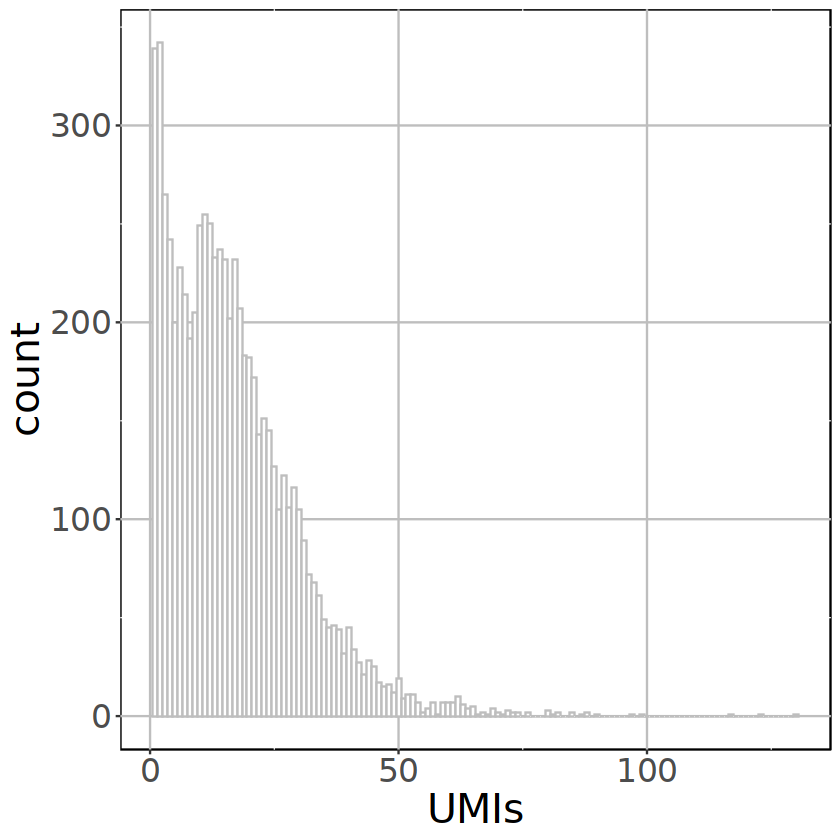

In [55]:
# Plot distribution of number of UMIs observed per cell and lineage barcode
ggplot(scars.output.umis) +
  geom_histogram(aes(x = UMIs), binwidth = 1, fill = 'white',color = 'grey') +
  scale_x_continuous()

### Further filtering on the integration-ID level

In [117]:
# Reload data
scar_name <- "dsRedRecCas"
dat_name <- "multi_seq_19"

scars.output.2 <- read.csv(paste0('scar_output_2_',dat_name,'_',scar_name,".csv"), stringsAsFactors = F, row.names = 1)


#### Extract valid integration ID combinations or integration ID 1 (position 5' of the target sequence)
Across sequencing runs and lineage barcode types, integration ID 1 is the one that is being consistently sequenced.  
Here, we therefore focus on the integration ID 1, so that the pipeline is universally usable across samples and read lengths.
The integration ID is 7 bp long with a G in the middle!

In [119]:
# extract valid integration IDs at 5' end of cassette
scars.output.2$intID_1 <- ''
scars.output.2$intID_1 <- substr(sapply(strsplit(scars.output.2$Sequence, "TTCCTGTAG"), "[", 2),1,7)

# Get combination and assess how frequently we observe each

valid_ids <- as.data.frame(table(scars.output.2$intID_1))
colnames(valid_ids) <- c('intID','Freq')
valid_ids <- valid_ids[order(valid_ids$Freq, decreasing = T),]

head(valid_ids, n = 10)

,intID,Freq
,<fct>,<int>
4,GATGTCA,2461
10,TTCGTGC,2005
6,TGCGATC,1413
8,TGTGACG,993
1,CGCGATC,1
2,CGTGACG,1
3,GAACAGT,1
5,TGCGAGC,1
7,TGCGTGC,1


Have a look at the frequency of observed sequence IDs and set a cutoff, so that you keep all good-looking integration IDs.  
The cutoff should be sensible regarding the general numbers observed.  
In this case, the first five IDs are valid. They have over 900 entries, while all others have only 1.

In [120]:
# Remove all lineage barcode sequences that have one of the invalid integration IDs

# Set cut-off for integration ID selection (based on assessment above)
freq_co <- 900

valid_ids <- valid_ids[order(valid_ids$Freq, decreasing = T),]
valid_ids <- valid_ids[valid_ids$Freq >= freq_co,]

valid_ids <- as.character(valid_ids$intID)


scars_output_filt <- scars.output.2[scars.output.2$intID_1 %in% valid_ids,]

nrow(scars.output.2)
nrow(scars_output_filt)


[1] 6881

[1] 6872

#### Separate integration ID sequence and lineage barcode sequence

In [121]:
# Extract lineage barcode sequences
scars_output_filt$seq_id <- substr(scars_output_filt$Sequence, 34,130)


#### Filter lineage barcodes / cells with multiple lineage barcode sequences in one integration ID
The rationale here is that each integration ID within a cell can only carry one scar sequence. If an integration ID within a single cell has multiple sequences, we need to remove all but one or remove the cell alltogether, if it's unclear which of the scars is the real one.

In [123]:
scars_output_filt$CBC_intid <- paste(scars_output_filt$Barcode, scars_output_filt$intID_1, sep = '_')

scars_output_filt$CBC_intid_seqid <- paste(scars_output_filt$Barcode, scars_output_filt$intID_1, scars_output_filt$Sequence, sep = '_')

# Summarize the dataframe, summing UMIs and picking the first value for all other columns
scars_output_summar <- scars_output_filt %>%
  group_by(CBC_intid_seqid) %>%
  summarise(
    UMIs = sum(UMIs, na.rm = TRUE),
    across(.cols = everything(), .fns = first, .names = "{.col}"),
    .groups = 'drop'
  )


table(duplicated(scars_output_summar$CBC_intid_seqid))

# Calculate cumulative sum and fraction of UMIs per CBC_intid

scars_output_summar <- scars_output_summar[order(scars_output_summar$UMIs, decreasing = T),]
scars_output_summar <- scars_output_summar[order(scars_output_summar$CBC_intid),]


scars_output_summar <- scars_output_summar %>%
  group_by(CBC_intid) %>%
  mutate(umi_frac = UMIs / sum(UMIs),
         umi_cumsum = cumsum(umi_frac)) %>%
  ungroup()


# Save output
write.table(scars_output_summar,paste0("cells_alleles_UMI_stats_dsRedRecCas_",dat_name,".csv"), sep = ",", quote = F)



FALSE 
 6845 

In [124]:
# Reload
all_cell_UMIs <- read.delim(paste0("cells_alleles_UMI_stats_dsRedRecCas_",dat_name,".csv"), stringsAsFactors = F, sep = ',')

table(duplicated(all_cell_UMIs$CBC_intid))
# -> There are some cells that have conflicting information on one transgene integration!
# -> Additional filtering is needed!


FALSE  TRUE 
 5941   904 

In [125]:
## UMI-filtering -> Here, we require a given sequence on a specific integration ID to contribute at least 60 % of the UMIS of that integration ID in a given cell
## This was adapted from the filtering of scars on endogenous targets, where we specifically look for cells with one or two certain scars, not more. Here, we expect one single scar, i.e. seq_id per cell and per integration ID. 
dim(all_cell_UMIs)
umifrac <- 0.6
      
    subdatf <- all_cell_UMIs
    
    all_cell_UMIs$molid <- paste0(all_cell_UMIs$CBC_intid,all_cell_UMIs$seq_id)
    #####

        # Save cells that only have one scar sequence per integration ID
        cellsonetwo <- as.data.frame(table(all_cell_UMIs$CBC_intid))
        cellsonetwo <- cellsonetwo$Var1[cellsonetwo$Freq == 1]

        cell_UMIs_onetwo <- all_cell_UMIs[all_cell_UMIs$CBC_intid %in% cellsonetwo,]    

        # Get cells that have more than one scar
        cellsmore <- as.data.frame(table(all_cell_UMIs$CBC_intid))
        cellsmore <- cellsmore$Var1[cellsmore$Freq > 1]

        cell_UMIs_more <- all_cell_UMIs[all_cell_UMIs$CBC_intid %in% cellsmore,]

        # Only keep cells that have a scar above the fraction cutoff
        
        cells_cutoff <- cell_UMIs_more[cell_UMIs_more$umi_frac > umifrac,]


        # clean up original UMI-file
        all_cell_UMIs <- all_cell_UMIs[all_cell_UMIs$molid %in% c(cells_cutoff$molid,cell_UMIs_onetwo$molid),]


dim(all_cell_UMIs)

[1] 6845   15

[1] 5515   16

png 
  2

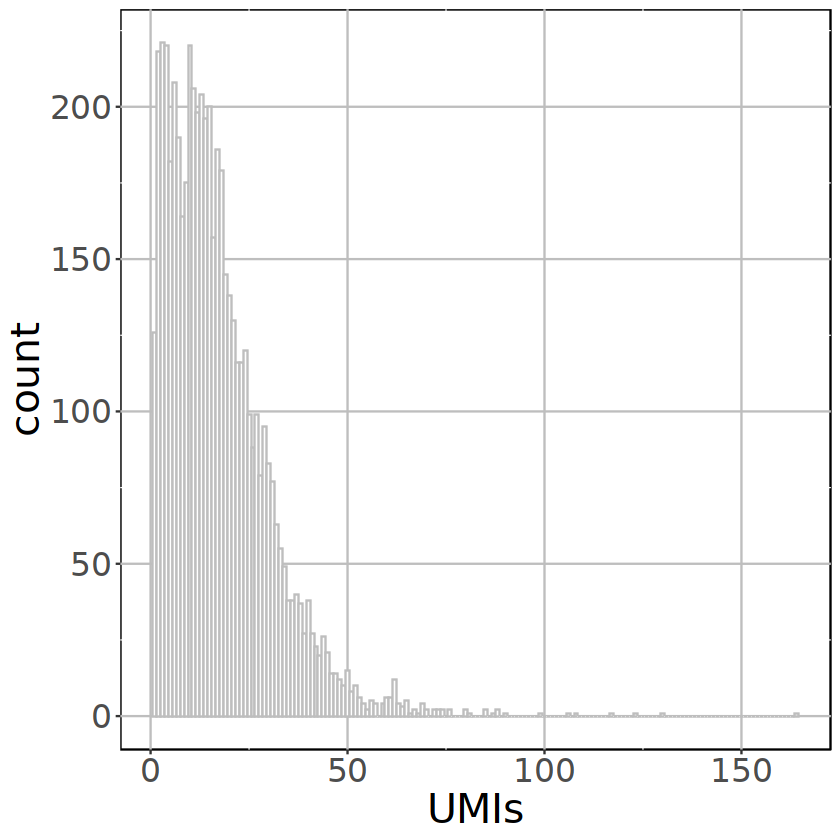

In [126]:
# Remove sequences with very few UMIs. Plot the distribution of UMI-counts per lineage barcode and cell and set a filtering cut-off based on this below.

png(paste0("pics/Scar_UMINumber_Histogram_",dat_name,'_',scar_name,".png"), width = 5, height = 4, units = 'in', res = 300)
  print(
      ggplot(all_cell_UMIs) +
        geom_histogram(aes(x = UMIs), binwidth = 1, fill = 'white',color = 'grey') +
        scale_x_continuous()
    )
dev.off()

ggplot(all_cell_UMIs) +
  geom_histogram(aes(x = UMIs), binwidth = 1, fill = 'white',color = 'grey') +
  scale_x_continuous()


In [127]:
# Set cut-off based on histogram. Filter data
umi_min <- 2

all_cell_UMIs <- all_cell_UMIs[all_cell_UMIs$UMIs >= umi_min,]

print(paste0('Filtered lineage barcode data on dsRedRecCas exists for ', length(unique(all_cell_UMIs$Barcode)), ' cells.'))

[1] "Filtered lineage barcode data on dsRedRecCas exists for 3678 cells."


In [128]:
write.table(all_cell_UMIs,paste0("cells_alleles_UMI_filtered_dsRedRecCas_",dat_name,".csv"), sep = ",", quote = F)


### Plot filtered transgene lineage barcodes

In [78]:
# Reload data
dat_name <- "multi_seq_19"

scars_output_filt <- read.delim(paste0("cells_alleles_UMI_filtered_dsRedRecCas_",dat_name,".csv"), stringsAsFactors = F, sep = ',')

scars_output_filt_sub <- scars_output_filt
scars_output_filt_sub$intid_seq_id <- paste0(scars_output_filt_sub$intID_1,'_', scars_output_filt_sub$seq_id)


In [79]:
# get matrix of cell barcode vs seq_id with integration id
allls_cbs <- as.data.frame.matrix(table(scars_output_filt_sub$Barcode, scars_output_filt_sub$intid_seq_id))
table(rowSums(allls_cbs))
allls_cbs$Barcode <- rownames(allls_cbs)


# Add some metadata info (the column specifications in the left_join will depend on the metadata info that you have and want to use
allls_cbs <- allls_cbs[!duplicated(allls_cbs$Barcode),]
table(duplicated(allls_cbs$Barcode))


cell_info <- left_join(allls_cbs, cell_anno[,c("Barcode","seurat_clusters","fish_all")], by = "Barcode")

rownames(cell_info) <- cell_info$Barcode

allls_cbs$Barcode <- NULL

scar_info <- scars_output_filt_sub[,c('Barcode', 'intID_1')]



   1    2    3    4    5 
2095 1310  225   46    2 


FALSE 
 3678 

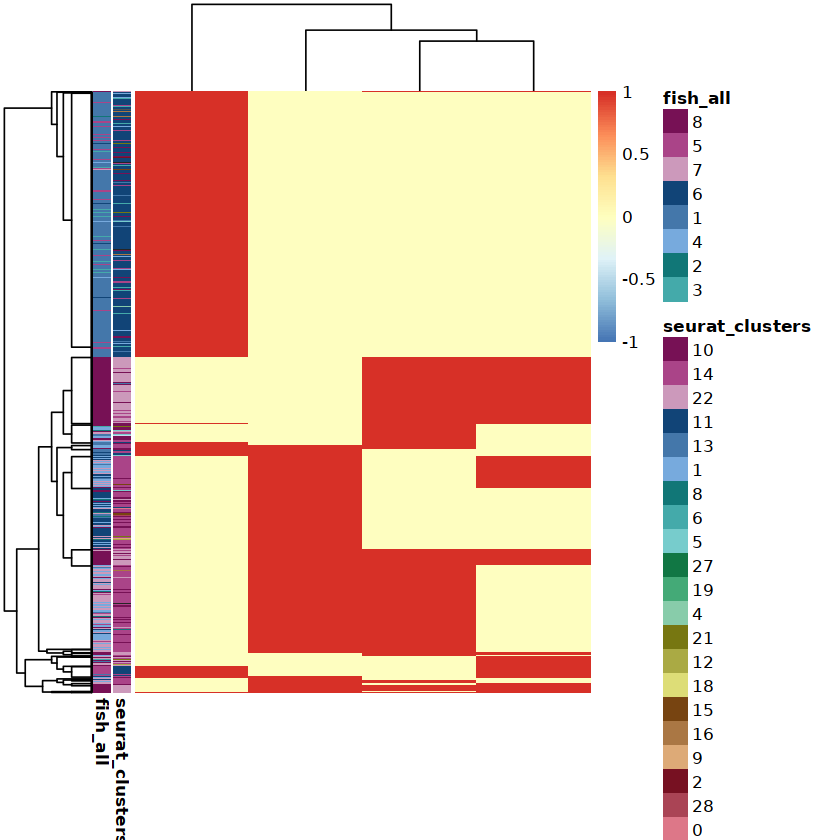

In [80]:
# Plot. Specify colors. Adjust this to the metadata columns that you want to use.

cols_celltype <- tol21rainbow[1:length(unique(cell_info$seurat_clusters))]
names(cols_celltype) <- unique(cell_info$seurat_clusters)

cols_tumour <- tol21rainbow[1:length(unique(cell_info$fish_all))]
names(cols_tumour) <- unique(cell_info$fish_all)

cols_scar <- tol21rainbow[1:length(unique(scar_info$seq_id))]
names(cols_scar) <- unique(scar_info$seq_id)

ann_colors = list(
    seurat_clusters = cols_celltype,
    fish_all = cols_tumour,
    seq_id = cols_scar
)


ploto <- pheatmap(allls_cbs,
  show_rownames = FALSE, show_colnames = FALSE,
  breaks = seq(-1, +1, length = 101),
  annotation_row = cell_info[,c("seurat_clusters","fish_all")],
  #annotation_col = scar_info,
  annotation_colors = ann_colors
)

ggsave(plot = ploto, filename = paste0("pics/dsRedRecCas_CIGARs_",dat_name,"_heatmap.png"), width = 6.5, height = 10, dpi = 300)


#### Remove wildtype sequences and plot again

In [81]:
# Define wildtype sequences
scars_output_filt_sub$wt <- 'no'

scars_output_filt_sub$wt[scars_output_filt_sub$Sequence %like any% c('%TCCGGAGGTGTCCACGTAGTAGTAGCCGGGGTTACAGGAACAGTACGAGCGCTCCGAGGGTTAACCGGACGGCGGCCACTACCTGGTGG%')] <- 'yes'

# Remove wildtype sequences
scars_output_filt_sub <- scars_output_filt_sub[scars_output_filt_sub$wt == 'no',]


In [82]:
# get matrix of cell barcode vs seq_id with integration id
allls_cbs <- as.data.frame.matrix(table(scars_output_filt_sub$Barcode, scars_output_filt_sub$intid_seq_id))
table(rowSums(allls_cbs))
allls_cbs$Barcode <- rownames(allls_cbs)


# Add some metadata info (the column specifications in the left_join will depend on the metadata info that you have and want to use
allls_cbs <- allls_cbs[!duplicated(allls_cbs$Barcode),]
table(duplicated(allls_cbs$Barcode))


cell_info <- left_join(allls_cbs, cell_anno[,c("Barcode","seurat_clusters","fish_all")], by = "Barcode")

rownames(cell_info) <- cell_info$Barcode

allls_cbs$Barcode <- NULL

scar_info <- scars_output_filt_sub[,c('Barcode', 'intID_1')]



  1   2   3   4 
949 566 128  43 


FALSE 
 1686 

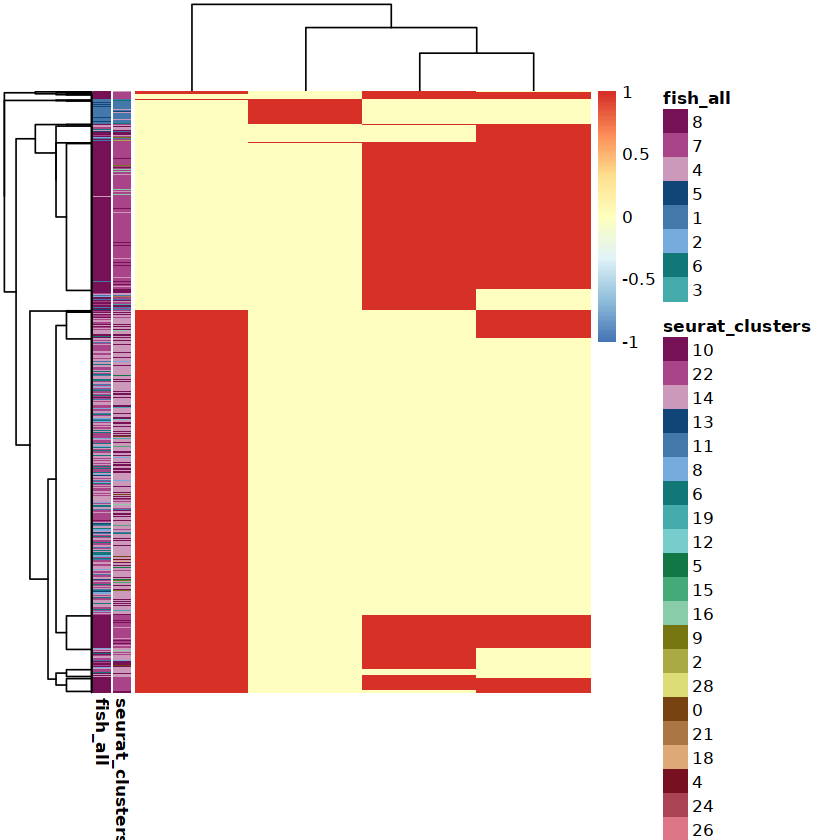

In [85]:
# Specify colors. Again, adjust this to the metadata columns that you want to use.

cols_celltype <- tol21rainbow[1:length(unique(cell_info$seurat_clusters))]
names(cols_celltype) <- unique(cell_info$seurat_clusters)

cols_tumour <- tol21rainbow[1:length(unique(cell_info$fish_all))]
names(cols_tumour) <- unique(cell_info$fish_all)

cols_scar <- tol21rainbow[1:length(unique(scar_info$seq_id))]
names(cols_scar) <- unique(scar_info$seq_id)


ann_colors = list(
    seurat_clusters = cols_celltype,
    fish_all = cols_tumour,
    seq_id = cols_scar
)


ploto <- pheatmap(allls_cbs,
  show_rownames = FALSE, show_colnames = FALSE,
  breaks = seq(-1, +1, length = 101),
  annotation_row = cell_info[,c("seurat_clusters","fish_all")],
  #annotation_col = scar_info,
  annotation_colors = ann_colors

)
ggsave(plot = ploto, filename = paste0("pics/dsRedRecCas_CIGARs_",dat_name,"_wo_wildtype_heatmap.png"), width = 6.5, height = 10, dpi = 300)


## Merge seq-IDs from all target genes

In [234]:
load('/data/multi_bAllos_4/multi_bAllos_4_clustered.Robj')

Idents(dat) <- "orig.ident"
dat_sub <- subset(dat, idents = c('multi_bAllos_4_lateAllos_02_S2'))

# Transfer cell type annotation from Seurat object into dataframe and make sure cell barcodes do not have character extensions that prohibit matching to cell barcodes in the lineage data.
cell_anno <- dat_sub@meta.data
cell_anno$Barcode <- rownames(cell_anno)


In [246]:
# DETERMINE WHETHER YOU WANT TO KEEP WT sequences. FALSE is recommended!
with_wt <- FALSE

# Set other parameters for recovery of endogenous target genes:
dat_name <- 'multi_seq_19'
dat_wd  <- paste0(getwd())
genes_list <- c("actb1","actb2","rpl39","cfl1","rpl18a")
tums_list <- 'all'

In [247]:
# This can be done per sample, but in practice, running it for all tumors from an allograft dataset is best (tum_it <- 'all').

for(i in 1:length(tums_list)){

    tum_it <- tums_list[i]

# Load dsRedRecCas data and cross-reference with Seurat cell metadata

    scars_output_filt <- read.delim(paste0('cells_alleles_UMI_filtered_dsRedRecCas_',dat_name,'.csv'), stringsAsFactors = F, sep = ',')

    scars_output_filt_sub <- scars_output_filt[scars_output_filt$Barcode %in% cell_anno$Barcode ,]
    scars_output_filt_sub$comb_seq_id <- paste0(scars_output_filt_sub$intID_1,'_', scars_output_filt_sub$seq_id)

    # Remove wildtype sequences

    scars_output_filt_sub$wt <- 'no'

    scars_output_filt_sub$wt[scars_output_filt_sub$Sequence %like any% c('%TCCGGAGGTGTCCACGTAGTAGTAGCCGGGGTTACAGGAACAGTACGAGCGCTCCGAGGGTTAACCGGACGGCGGCCACTACCTGGTGG%')] <- 'yes'

    if(with_wt == F){
        scars_output_filt_sub <- scars_output_filt_sub[scars_output_filt_sub$wt == 'no',]
    }

    # Remove lineage barcodes that appear in only very few cells

    clone_freqs <- as.data.frame(table(scars_output_filt_sub$comb_seq_id))
    clone_freqs <- clone_freqs$Var1[clone_freqs$Freq >= 5]
    scars_output_filt_sub <- scars_output_filt_sub[scars_output_filt_sub$comb_seq_id %in% clone_freqs,]

    # Load endogenous target gene data 
    scar_file_list <- load_single_target_comb_seq_ids(dat_wd = dat_wd,
                                                      dat_name = dat_name,
                                                      tum_it = tum_it,
                                                      genes_list = genes_list
                                                     )  
    
    
    # Merge into one big file for all endogenous target genes
    num_targs <- length(scar_file_list)

    if(num_targs == 1){

        all_scars <- scar_file_list[[1]]

    }else if(num_targs == 2){

        all_scars <- rbind(scar_file_list[[1]], scar_file_list[[2]])

    }else if(num_targs == 3){

        all_scars <- rbind(scar_file_list[[1]], scar_file_list[[2]],scar_file_list[[3]])

    }else if(num_targs == 4){

        all_scars <- rbind(scar_file_list[[1]], scar_file_list[[2]],scar_file_list[[3]],scar_file_list[[4]])

    }else if(num_targs == 5){

        all_scars <- rbind(scar_file_list[[1]], scar_file_list[[2]],scar_file_list[[3]],scar_file_list[[4]],scar_file_list[[5]])

    }

    all_scars$cloneIDBC <- paste0(all_scars$Barcode, all_scars$cloneID)
    all_scars <- all_scars[!duplicated(all_scars$cloneIDBC),]

    # Save merged endogenous target data
    write.csv(all_scars, paste0("all_endo_combSeqIDpairs_",dat_name,"_",tum_it,".csv"), quote = F)


    # Remove wildtpye seqs:

    if(with_wt == F){
        all_scars <- all_scars[!(all_scars$cloneID %like any% "%WT"),]
    }
    
# Merge dsRedRecCas and endogenous target data
    all_scars <- all_scars[,c('Barcode','Gene','comb_seq_id')]
    colnames(all_scars) <- c('Barcode','Gene','comb_seq_id')

    if(nrow(scars_output_filt_sub) == 0){
        all_scars_ext <- all_scars

    }else{
        scars_output_filt_sub$Gene <- paste0('dsRedRecCas_', gsub("(.+?)(\\_.*)", "\\1", scars_output_filt_sub$comb_seq_id))

        scars_output_filt_sub <- scars_output_filt_sub[,c('Barcode','Gene','comb_seq_id')]

        all_scars_ext <- rbind(all_scars, scars_output_filt_sub)

    }


    if(with_wt == T){
        write.csv(all_scars_ext, paste0('all_target_combSeqIDpairs_',dat_name,'_tum_',tum_it,'_withWTcells.csv'), quote = F)
    }else{
        write.csv(all_scars_ext, paste0('all_target_combSeqIDpairs_',dat_name,'_tum_',tum_it,'.csv'), quote = F)
    }
    
    
    
}

[1] "Loaded comb_seq_ids for gene actb1"
[1] "Loaded comb_seq_ids for gene actb2"
[1] "Loaded comb_seq_ids for gene rpl39"
[1] "Loaded comb_seq_ids for gene cfl1"
[1] "Loaded comb_seq_ids for gene rpl18a"
[1] "Highest comb_seq_id file number: 5"


### Add combinations of seq-IDs observed in cells

In [248]:
# Add combinations of comb_seq_ids

# Extract cell barcode comb_seq_id combos
bc_seqs <- as.data.frame(table(all_scars_ext$comb_seq_id, all_scars_ext$Barcode))
bc_seqs <- bc_seqs[bc_seqs$Freq > 0,]    
bc_seqs$Freq <- NULL
colnames(bc_seqs) <- c('comb_seq_id', 'Barcode')
table(is.na(bc_seqs$comb_seq_id))

all_scars_ext$BC_comb_seq_id <- paste0(all_scars_ext$Barcode, '_', all_scars_ext$comb_seq_id)
all_scars_ext <- all_scars_ext[!duplicated(all_scars_ext$BC_comb_seq_id),]
all_scars_ext$BC_comb_seq_id <- NULL



FALSE 
 7533 

In [249]:
# Add all combinations of comb_seq_IDs that are seen in a cell

result <- bc_seqs %>%
  group_by(Barcode) %>%
  summarise(code_combinations = sapply(strsplit(paste(sort(unique(comb_seq_id)), collapse = ","), ","), function(x) {
    unlist(sapply(1:length(x), function(size) combn(x, size, simplify = TRUE, FUN = function(y) paste(y, collapse = ""))))
  })) %>%
  unnest(cols = code_combinations)


Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()` always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'Barcode'. You can override using the `.groups` argument.


In [250]:
all_clones_min <- all_scars_ext[!duplicated(all_scars_ext$Barcode),]
all_clones_ext <- left_join(result, all_clones_min, by = 'Barcode')


## Assign late allograft cells to tumor of origin using clones called from individual primary tumors

### Get seq-ID clone assignments from primary tumours
These are printed out to a file named similar to this during clone_def: paste0('all_combseqid_combinations_with_cloneAssignments_',dat_name,'_',tum_it,'_lowResolutionClones_resCutoff_0.25.csv')  
  
These also include combinations of seq-IDs, hereafter called **code combinations** observed in the same cell that are definitive of a clone. Extending to code combinations increases the likelihood of being able to assign a graft cell to a primary tumor.

In [251]:
# Load cell sample information from primary tumors
Idents(dat) <- "orig.ident"
dat_sub <- subset(dat, idents = c("multi_bAllos_4_PTs_S1","multi_bAllos_4_PTs_S2"))

# Transfer cell type annotation from Seurat object into dataframe and make sure cell barcodes do not have character extensions that prohibit matching to cell barcodes in the lineage data.
cell_anno <- dat_sub@meta.data
cell_anno$Barcode <- rownames(cell_anno)
cell_anno$sample_inf <- cell_anno$fish_all


In [168]:
tums_list <- unique(cell_anno$fish_all)

clones_list <- list()

dat_name <- 'multi_bAllos_4_tum'

for(i in 1:length(tums_list)){

    tum_it <- tums_list[i]
    clones_list[[i]] <- read.delim(paste0('/data/multi_bAllos_4/lineage/all_combseqid_combinations_with_cloneAssignments_',dat_name,'_',tum_it,'_lowResolutionClones_resCutoff_0.25.csv'), sep = ',', stringsAsFactors = F, row.names = 1)
    clones_list[[i]]$fish_all <- tum_it
    names(clones_list)[i] <- tums_list[i]
    
}

all_clones <- do.call('rbind', clones_list)


In [252]:
# Flag combinations that are unique to a fish and can be used to identify it!
# Get the fraction of cells carrying a specific code combination that belong to a fish.

tum_scar <- as.data.frame(table(all_clones$fish_all, all_clones$code_combinations))

colnames(tum_scar) <- c('fish_all','code_combinations','freq')

for(i in c(1:length(unique(all_clones$code_combinations)))){

    scar_i <- unique(all_clones$code_combinations)[i]
    
    dat_i <- tum_scar[tum_scar$code_combinations == scar_i,]

    
    dat_i$frac <- dat_i$freq/(sum(dat_i$freq))


    if(i == 1){
        
        tum_scar_frac <- dat_i
        
    }else{
    
        tum_scar_frac <- rbind(tum_scar_frac, dat_i)
        
    }

}

In [253]:
# Only keep sequence combinations that can be assigned to a single fish with high certainty, i.e. 90 % of cells with the combination are from one fish.
# And only keep cells that have the combination and were assigned to the correct fish!
tum_scar_frac_conf <- tum_scar_frac[tum_scar_frac$frac >= 0.9,]
tum_scar_frac_conf$sample_inf_code_combination <- paste0(tum_scar_frac_conf$fish_all,'_', tum_scar_frac_conf$code_combinations)
all_clones$sample_inf_code_combination <- paste0(all_clones$fish_all,'_', all_clones$code_combinations)

all_clones$pt_fish_defining <- FALSE
all_clones$pt_fish_defining[all_clones$sample_inf_code_combination %in% tum_scar_frac_conf$sample_inf_code_combination] <- TRUE

unique_clones <- all_clones[all_clones$sample_inf_code_combination %in% tum_scar_frac_conf$sample_inf_code_combination,]


In [254]:
write.csv(unique_clones, 'onlyPTFishDefining_seqIDcombinations_from_individual_tums_PTs.csv', quote = F)

write.csv(all_clones, 'all_seqIDcombinations_from_individual_tums_PTs.csv', quote = F)

In [409]:
# Save a small example table subset for 50 cells:
unique_clones <- read.delim('onlyPTFishDefining_seqIDcombinations_from_individual_tums_PTs.csv', sep = ',', stringsAsFactors = F, header = T)

set.seed(234)
sample_cell_set <- sample(unique(unique_clones$Barcode),50)

unique_clones_subset <- unique_clones[unique_clones$Barcode %in% sample_cell_set,]

write.csv(unique_clones_subset, 'onlyPTFishDefining_seqIDcombinations_from_individual_tums_PTs_50exampleCells.csv', quote = F)

### Assign late allograft cells to primary tumor clones
Use the combined seq ids that were just extracted, not filtered in any way here!

In [301]:
# Load the CSV of PT-fish-defining clone assignments
unique_clones <- read.delim('onlyPTFishDefining_seqIDcombinations_from_individual_tums_PTs.csv', sep = ',', stringsAsFactors = F, header = T)

print(paste0(table(unique(all_clones_ext$code_combinations) %in% unique_clones$code_combinations)[2],
               ' out of ',
               length(unique(all_clones_ext$code_combinations)),
               ' code combinations found in allograft cells were found in a primary tumor and are definitive of a primary tumor or PT clone of origin.'
              )
      )

print(paste0(table(unique(unique_clones$code_combinations) %in% all_clones_ext$code_combinations)[2],
               ' out of ',
               length(unique(unique_clones$code_combinations)),
               ' code combinations found in primary tumor and definitive of a primary tumor or PT clone were found in a late allograft cell.'
              )
      )

[1] "175 out of 394 code combinations found in allograft cells were found in a primary tumor and are definitive of a primary tumor or PT clone of origin."
[1] "175 out of 2065 code combinations found in primary tumor and definitive of a primary tumor or PT clone were found in a late allograft cell."


In [302]:
# Keep only unique_clones rows whose code_combinations exist in the allograft data
unique_clones <- unique_clones[unique_clones$code_combinations %in% all_clones_ext$code_combinations,]


# Add a composite key to de-duplicate exact (code_combination, clone) pairs
unique_clones$clone_code_combo <- paste0(unique_clones$code_combinations, '_', unique_clones$inferred_clone_NAless)
# Remove duplicates
unique_clones <- unique_clones[!duplicated(unique_clones$clone_code_combo),]


In [303]:
# Check whether certain code_combinations are still indicative of multiple clones
# These can for example be definitive of a tumor, but not of a specific clone. Such ambiguities will be resolved later.

test <- as.data.frame(table(unique_clones$code_combinations, unique_clones$inferred_clone_NAless))
test <- test[test$Freq > 0,]
if(TRUE %in% names(table(duplicated(test$Var1)))){
    print('There are code combinations that are definitive of multiple clones')
}
rm(test)


[1] "There are code combinations that are definitive of multiple clones"


In [304]:
#all_clones_ext <- all_clones_ext[all_clones_ext$code_combinations %in% unique_clones$code_combinations,]

# Merge allograft code combinations with primary tumor code combinations and associated clone info

# Keep and rename only the columns needed for the join
unique_clones <- unique_clones[,c('fish_all','code_combinations','fish_clone','inferred_clone')]
colnames(unique_clones) <- c('pt_fish','code_combinations','fish_clone','inferred_clone')

# Join clone assignments onto the full cell table by code_combinations
all_scars_ext_cl <- left_join(all_clones_ext, unique_clones, by = 'code_combinations', relationship = "many-to-many")

# Make NA-free helper columns where missing assigment of a primary tumor is encoded as 'none'
all_scars_ext_cl$pt_fish_NAless <- all_scars_ext_cl$pt_fish
all_scars_ext_cl$pt_fish_NAless[is.na(all_scars_ext_cl$pt_fish_NAless)] <- 'none'

all_scars_ext_cl$inferred_cloneNAless <- all_scars_ext_cl$inferred_clone
all_scars_ext_cl$inferred_cloneNAless <- as.character(all_scars_ext_cl$inferred_cloneNAless)
all_scars_ext_cl$inferred_cloneNAless[is.na(all_scars_ext_cl$inferred_cloneNAless)] <- 'none'


In [305]:
# Enforce: one PT fish per allograft cell barcode

# Make sure each cell was only assigned to one primary tumour
pt_per_cell <- as.data.frame(table(all_scars_ext_cl$Barcode, all_scars_ext_cl$pt_fish_NAless))
colnames(pt_per_cell) <- c('Barcode', 'pt_fish_NAless', 'Freq')
pt_per_cell <- pt_per_cell[pt_per_cell$Freq > 0,]

# Set 'none' as 0 so it won't contribute to conflicts
pt_per_cell$Freq[pt_per_cell$pt_fish_NAless == 'none'] <- 0

# Keep only barcodes that are duplicated (i.e., potentially conflicting primary tumor assignments to a single allograft cell)
ques <- pt_per_cell$Barcode[duplicated(pt_per_cell$Barcode)]
pt_per_cell <- pt_per_cell[pt_per_cell$Barcode %in% ques,]
pt_per_cell$bc_sample <- paste0(pt_per_cell$Barcode,'_',pt_per_cell$pt_fish_NAless)

# Rescue the barcodes that have been assigned to a tumor with multiple lines of evidence, i.e. that have many code_combinations pointing to one tumor and few to another.
# Approach: within each barcode, for now keep only barcode–PT rows whose count
# is <= 80% of the barcode's total evidence (i.e., drop the clear majority).
# The remaining are the truly ambiguous pairs to remove downstream.
# Only keep the truly ambiguous barcode-tumor combinations in the table.
pt_per_cell <- pt_per_cell %>%
  group_by(Barcode) %>%
  filter(Freq <= (sum(Freq)*0.8)) %>%
  ungroup()

# Then remove the remaining questionable entries from the table.
all_scars_ext_cl$bc_sample <- paste0(all_scars_ext_cl$Barcode,'_',all_scars_ext_cl$pt_fish_NAless)

all_scars_ext_cl <- all_scars_ext_cl[!all_scars_ext_cl$bc_sample %in% pt_per_cell$bc_sample,]


In [306]:
# Enforce: one clone per barcode

pt_per_cell <- as.data.frame(table(all_scars_ext_cl$Barcode, all_scars_ext_cl$inferred_cloneNAless))
colnames(pt_per_cell) <- c('Barcode', 'pt_fish_NAless', 'Freq')
pt_per_cell <- pt_per_cell[pt_per_cell$Freq > 0,]

# Again, set 'none' as 0 so it won't contribute to conflicts
pt_per_cell$Freq[pt_per_cell$pt_fish_NAless == 'none'] <- 0

# Keep only barcodes that are duplicated (i.e., potentially conflicting primary tumor clone assignments to a single allograft cell)
ques <- pt_per_cell$Barcode[duplicated(pt_per_cell$Barcode)]

if(length(ques) != 0){
    print('found clone collision')
    pt_per_cell <- pt_per_cell[pt_per_cell$Barcode %in% ques,]
    pt_per_cell$bc_clone <- paste0(pt_per_cell$Barcode,'_',pt_per_cell$pt_fish_NAless)

    # Rescue the barcodes that have been assigned to a tumor with multiple lines of evidence, i.e. that have many code_combinations pointing to one clone and few to another.
    # Approach: Keep rows where Freq <= (sum(Freq)+1) - Freq  <=>  2*Freq <= sum(Freq)+1
    # i.e., exclude any single clone that has a strict majority from the table; those are *rescued*
    pt_per_cell_rem <- pt_per_cell %>%
      group_by(Barcode) %>%
      filter(Freq <= (sum(Freq)+1) - Freq) %>%
      ungroup()
    
    # Rows *not* in pt_per_cell_rem are rescued (clear majority clone).
    pt_per_cell_filt <- pt_per_cell[!pt_per_cell$bc_clone %in% pt_per_cell_rem$bc_clone,]
    
    # Split ambiguous vs rescued cell sets. These can overlap.
    pt_per_cell_ambi_clone <- pt_per_cell_rem[!pt_per_cell_rem$Barcode %in% pt_per_cell_filt$Barcode,] # cells that were not rescued
    pt_per_cell_rescued_clone <- pt_per_cell_rem[pt_per_cell_rem$Barcode %in% pt_per_cell_filt$Barcode,] # cells that were rescued
    
    # Remove the questionable entries from the main table. Rows *not* in pt_per_cell_rem are rescued (clear majority clone).
    all_scars_ext_cl$bc_clone <- paste0(all_scars_ext_cl$Barcode,'_',all_scars_ext_cl$inferred_cloneNAless)
    all_scars_ext_cl <- all_scars_ext_cl[!all_scars_ext_cl$bc_clone %in% pt_per_cell_rescued_clone$bc_clone,]
    
    # For truly ambiguous cases, set clone back to 'none'/NA
    all_scars_ext_cl$inferred_cloneNAless[all_scars_ext_cl$bc_clone %in% pt_per_cell_ambi_clone$bc_clone] <- 'none'
    all_scars_ext_cl$inferred_clone[all_scars_ext_cl$bc_clone %in% pt_per_cell_ambi_clone$bc_clone] <- NA
    
    # Recompute key
    all_scars_ext_cl$bc_clone <- paste0(all_scars_ext_cl$Barcode,'_',all_scars_ext_cl$inferred_cloneNAless)

}else{
    
   # No clone conflicts; just define the key
    all_scars_ext_cl$bc_clone <- paste0(all_scars_ext_cl$Barcode,'_',all_scars_ext_cl$inferred_cloneNAless)

}    


[1] "found clone collision"


In [313]:
# Label whether assignments succeeded and run final checks

# Flags introduced for cells: has assigned PT fish? has assigned PT clone?
all_scars_ext_cl$assigned_to_pt_fish <- 'no'
all_scars_ext_cl$assigned_to_pt_fish[!is.na(all_scars_ext_cl$pt_fish)] <- 'yes'
all_scars_ext_cl$assigned_to_pt_clone <- 'no'
all_scars_ext_cl$assigned_to_pt_clone[!is.na(all_scars_ext_cl$inferred_clone)] <- 'yes'

# 2x2 summary of assignment status
assign <- as.data.frame(table(all_scars_ext_cl$assigned_to_pt_fish, all_scars_ext_cl$assigned_to_pt_clone))
colnames(assign) <- c('assigned_to_pt_fish','assigned_to_pt_clone','number_of_cells')
assign

# Final consistency: each barcode should appear at most once per bc_clone key
testdf <- all_scars_ext_cl[!duplicated(all_scars_ext_cl$bc_clone),]

if(TRUE %in% names(table(duplicated(testdf$Barcode)))){
    print('There are remaining cells assigned to multiple clones. This should not be the case - go back and check your workflow.')
}else{
    print('Success! All cells have been assigned to either a single primary tumor or to none.')
}


assigned_to_pt_fish,assigned_to_pt_clone,number_of_cells
<fct>,<fct>,<int>
no,no,1902
yes,no,1051
no,yes,0
yes,yes,19943


[1] "Success! All cells have been assigned to either a single primary tumor or to none."


In [314]:
# Save output
write.csv(all_scars_ext_cl, 'unfiltered_comb_seq_ids_with_PT_assignment_lateAllos.csv', quote = F)

In [412]:
# Save a small example table subset for 50 cells:
set.seed(234)
sample_cell_set <- sample(unique(all_scars_ext_cl$Barcode),50)

all_scars_ext_cl_subset <- all_scars_ext_cl[all_scars_ext_cl$Barcode %in% sample_cell_set,]

write.csv(all_scars_ext_cl_subset, 'unfiltered_comb_seq_ids_with_PT_assignment_lateAllos_50exampleCells.csv', quote = F)

## Plot heatmaps of allograft cells with primary tumor clone assignments

In [380]:

Idents(dat) <- "orig.ident"
dat_sub <- subset(dat, idents = c('multi_bAllos_4_lateAllos_02_S2'))

# Transfer cell type annotation from Seurat object into dataframe and make sure cell barcodes do not have character extensions that prohibit matching to cell barcodes in the lineage data.
cell_anno <- dat_sub@meta.data
cell_anno$Barcode <- rownames(cell_anno)


In [381]:
clone_df_inf <- all_scars_ext_cl[!duplicated(all_scars_ext_cl$Barcode),]

In [382]:
# get matrix of cell barcode vs seq_id with integration id
allls_cbs <- as.data.frame.matrix(table(clone_df_inf$Barcode, clone_df_inf$inferred_cloneNAless))
table(rowSums(allls_cbs))
allls_cbs$Barcode <- rownames(allls_cbs)

# Add some metadata info (the column specifications in the left_join will depend on the metadata info that you have and want to use
allls_cbs <- allls_cbs[!duplicated(allls_cbs$Barcode),]
table(duplicated(allls_cbs$Barcode))


# Choose metadata columns to keep for plotting
cell_info <- left_join(allls_cbs, cell_anno[,c("Barcode","tumour_all","fish_all","celltype")], by = "Barcode")
cell_info$fish_all <- as.character(cell_info$fish_all)

rownames(cell_info) <- cell_info$Barcode
allls_cbs$Barcode <- NULL


# Prepare summarized metadata tables for plotting
scar_info <- as.data.frame(clone_df_inf[!duplicated(clone_df_inf$inferred_cloneNAless),])
rownames(scar_info) <- scar_info$inferred_cloneNAless

scar_info <- scar_info[order(scar_info$inferred_cloneNAless, decreasing = F),]

# Order main data to get the proper order of scars in the heatmap column
allls_cbs <-  allls_cbs[,order(match(colnames(allls_cbs),rownames(scar_info)))]



   1 
3001 


FALSE 
 3001 

In [391]:
# Define colours for heatmap annotation

# Create one dataframe for the actual cloneIDs
scar_info_clust <- as.data.frame(scar_info$inferred_cloneNAless)
rownames(scar_info_clust) <- rownames(scar_info)
colnames(scar_info_clust)[1] <- "inferred_cloneNAless"

cell_info$celltype <- as.character(cell_info$celltype)
cols_celltype <- tol21rainbow[1:length(unique(cell_info$celltype))]
names(cols_celltype) <- unique(cell_info$celltype)

cols_tumour <- tol21rainbow[1:length(unique(cell_info$tumour_all))]
names(cols_tumour) <- unique(cell_info$tumour_all)

cols_fish <- tol21rainbow[1:length(unique(cell_info$fish_all))]
names(cols_fish) <- unique(cell_info$fish_all)

cols_scar <- c(tol21rainbow[c(1,6,10,12,14,15,16,18,20,26,31,3,4,9,2,32)][1:(length(unique(scar_info_clust$inferred_cloneNAless))-1)], 'light grey')
names(cols_scar) <- unique(scar_info_clust$inferred_cloneNAless)


ann_colors = list(
    tumour_all = cols_tumour,
    fish_all = cols_fish,
    celltype = cols_celltype,
    inferred_cloneNAless = cols_scar
)

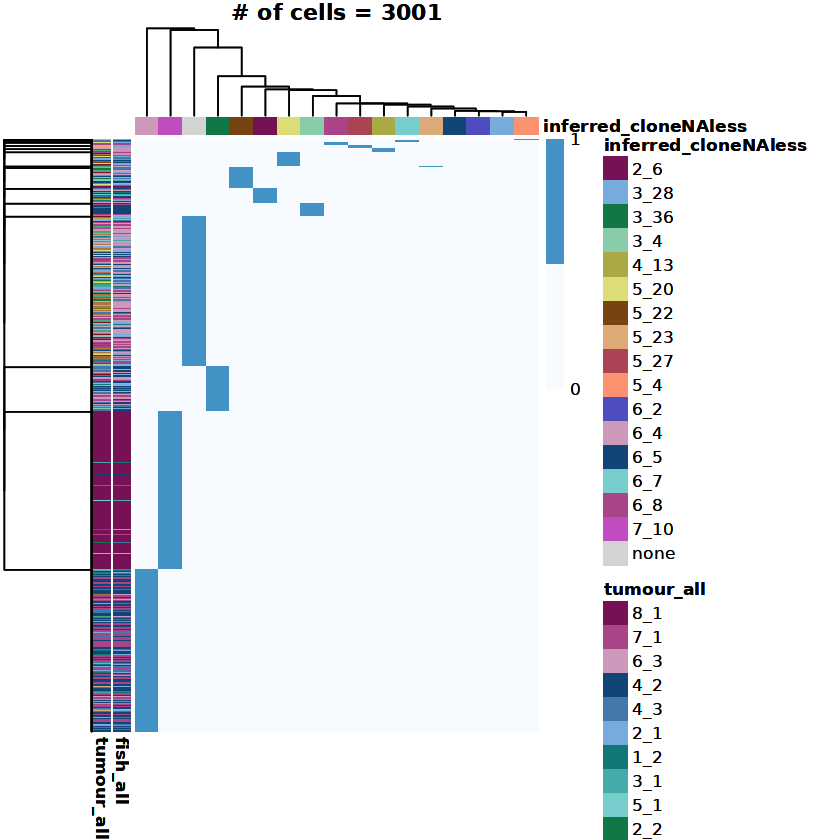

In [395]:
print(
    pheatmap(allls_cbs,
      show_rownames = FALSE, show_colnames = FALSE,
      annotation_row = cell_info[,c("fish_all","tumour_all")],
      color = colorRampPalette(c("#F7FBFF", "#4292C6"))(2),
      legend_breaks = seq(0,1) ,
      annotation_col = scar_info_clust,
      annotation_colors = ann_colors,
      cluster_cols = T,
      main = paste0('# of cells = ',length(unique(clone_df_inf$Barcode))),
    )
)

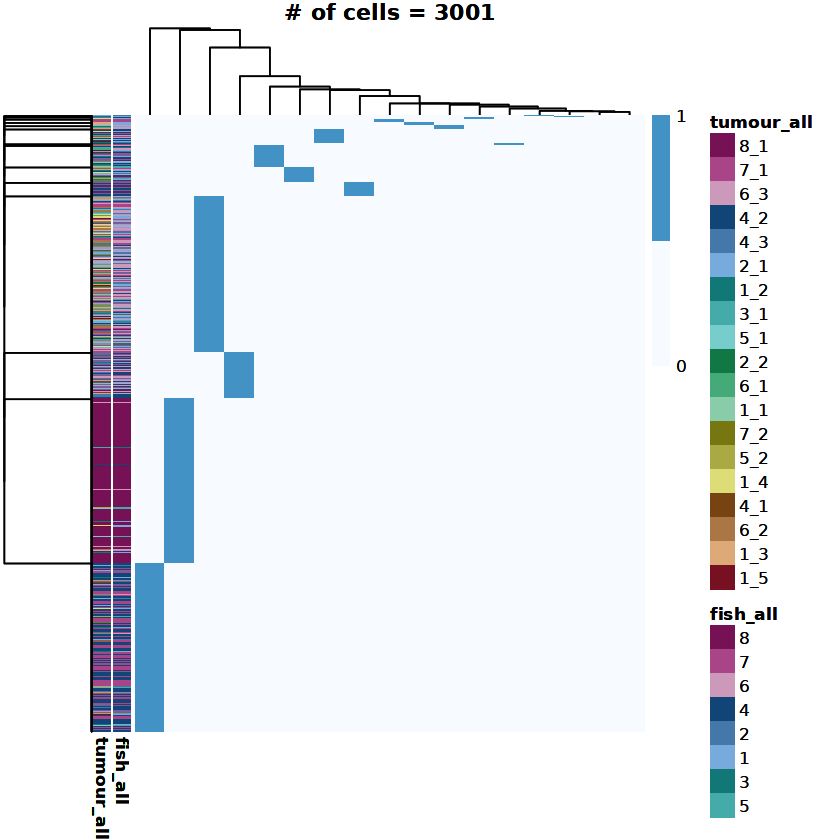

In [396]:
print(
    pheatmap(allls_cbs,
      show_rownames = FALSE, show_colnames = FALSE,
      annotation_row = cell_info[,c("fish_all","tumour_all")],
      color = colorRampPalette(c("#F7FBFF", "#4292C6"))(2),
      legend_breaks = seq(0,1) ,
      #annotation_col = scar_info_clust,
      annotation_colors = ann_colors,
      cluster_cols = T,
      main = paste0('# of cells = ',length(unique(clone_df_inf$Barcode))),
    )
)

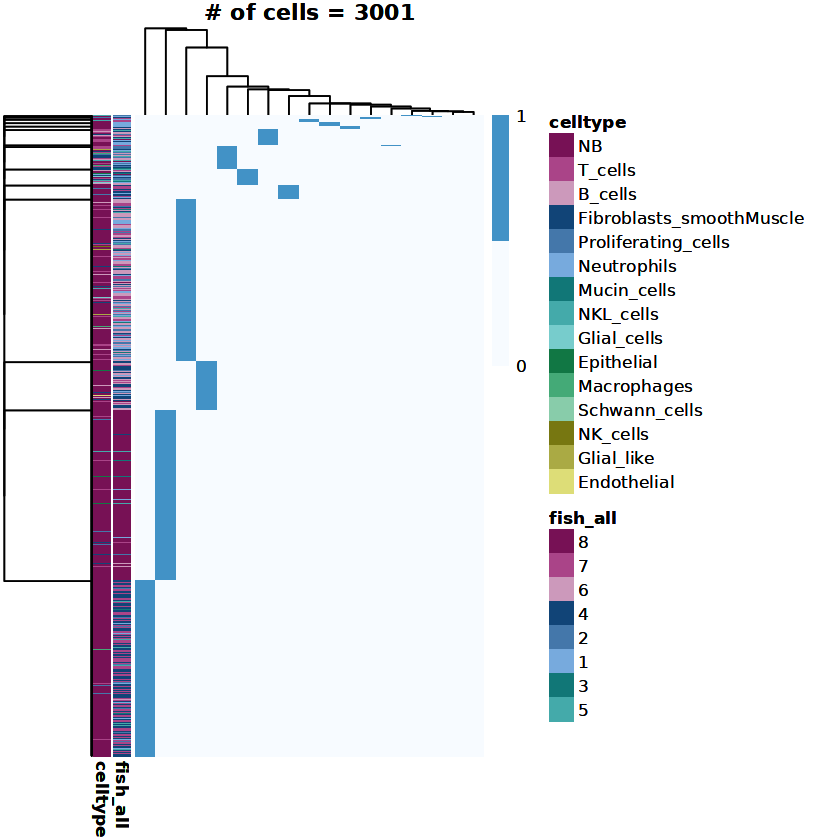

In [397]:
print(
    pheatmap(allls_cbs,
      show_rownames = FALSE, show_colnames = FALSE,
      annotation_row = cell_info[,c("fish_all","celltype")],
      color = colorRampPalette(c("#F7FBFF", "#4292C6"))(2),
      legend_breaks = seq(0,1) ,
      #annotation_col = scar_info_clust,
      annotation_colors = ann_colors,
      cluster_cols = T,
      main = paste0('# of cells = ',length(unique(clone_df_inf$Barcode))),
    )
)